In [109]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the base path for your data directory for Colab
    basePath = '/content/drive/MyDrive'

else:
    # Running locally or in a different environment
    basePath = '..'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [111]:
df = pd.read_csv('/content/drive/MyDrive/data/processed/grouped_data2.csv')

###**Essential Fns**

In [112]:
def filter_and_select_data(df, column_name, start_year):
    """Selects columns and filters data from a starting year."""
    selected_columns = ['COUNTRY', 'DATE', column_name]
    df_filtered = df[selected_columns].copy()
    return df_filtered[df_filtered['DATE'] >= start_year]

In [113]:
def get_sufficient_countries(df, column_name, completeness_threshold):
    """Returns a list of countries with data completeness >= a given threshold."""
    completeness = df.groupby('COUNTRY')[column_name].apply(lambda x: x.count() / len(x))
    return completeness[completeness >= completeness_threshold].index.tolist()

In [114]:
def split_data_by_year(df, train_end_year):
    """Splits a DataFrame into training and testing sets based on year."""
    df_train = df[df['DATE'] <= train_end_year].copy()
    df_test = df[df['DATE'] > train_end_year].copy()
    return df_train, df_test

In [115]:
def handle_missing_values(df, column_name):
    """Fills missing values in a DataFrame column using a sequence of
    interpolation, backfill, and forward fill, grouped by country.
    """
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.interpolate())
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.bfill())
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.ffill())
    return df

In [116]:
def ensure_consecutive_years(df, column_name, start_year, end_year=None):
    """
    Ensures a DataFrame has a complete time series of years for each country.
    Fills in missing years and interpolates data.
    """
    processed_dfs = []
    unique_countries = df['COUNTRY'].unique()
    for country in unique_countries:
        country_data = df[df['COUNTRY'] == country]
        if end_year is None:
            current_end_year = int(country_data['DATE'].max())
        else:
            current_end_year = end_year

        all_years = list(range(start_year, current_end_year + 1))
        country_years_df = pd.DataFrame({'COUNTRY': country, 'DATE': all_years})

        merged_country_df = pd.merge(country_years_df, country_data, on=['COUNTRY', 'DATE'], how='left')
        merged_country_df[column_name] = merged_country_df[column_name].interpolate()
        processed_dfs.append(merged_country_df)

    return pd.concat(processed_dfs, ignore_index=True)

In [117]:
def filter_by_common_countries(df_train, df_test, column_name):
    """
    Finds countries with at least one non-missing value in both training and
    testing DataFrames and filters both to include only those countries.

    Returns:
        tuple: A tuple containing the filtered training and testing DataFrames.
    """
    # Find countries in training data with at least one non-missing value
    countries_with_train_data = df_train.dropna(subset=[column_name])['COUNTRY'].unique()

    # Find countries in testing data with at least one non-missing value
    countries_with_test_data = df_test.dropna(subset=[column_name])['COUNTRY'].unique()

    # Find the intersection of these two lists
    common_countries = set(countries_with_train_data).intersection(set(countries_with_test_data))

    df_train_filtered = df_train[df_train['COUNTRY'].isin(common_countries)].copy()
    df_test_filtered = df_test[df_test['COUNTRY'].isin(common_countries)].copy()

    return df_train_filtered, df_test_filtered

In [118]:
def prepare_column_data_pipeline(df, column_name, start_year=1980, train_end_year=2010, completeness_threshold=0.8):
    """
    Main pipeline function to prepare and clean time series data for a specific column.
    """
    # Step 1: Filter and select data
    df_filtered = filter_and_select_data(df, column_name, start_year)

    # Step 2: Get a list of countries with sufficient data
    sufficient_countries = get_sufficient_countries(df_filtered, column_name, completeness_threshold)
    df_filtered = df_filtered[df_filtered['COUNTRY'].isin(sufficient_countries)].copy()

    # Step 3: Split into training and testing sets
    df_train, df_test = split_data_by_year(df_filtered, train_end_year)

    # Step 4: Handle missing values in both sets
    df_train = handle_missing_values(df_train, column_name)
    df_test = handle_missing_values(df_test, column_name)

    # Step 5: Find and filter for common countries (with non-missing data)
    # This is the corrected line
    df_train, df_test = filter_by_common_countries(df_train, df_test, column_name)

    # Step 6: Ensure a complete, consecutive time series
    df_train_completed = ensure_consecutive_years(df_train, column_name, start_year=start_year, end_year=train_end_year)
    df_test_completed = ensure_consecutive_years(df_test, column_name, start_year=train_end_year + 1)

    return df_train_completed, df_test_completed

###**Testing fns**

In [119]:
# Load the trimmed data
try:
    df = pd.read_csv(f'{basePath}/data/processed/trimmedData.csv')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("trimmedData.csv not found. Please ensure the path is correct and the file exists.")

print(f"The data TRIMMEDDATA is")
display(df)


# Now, let's use our new pipeline function to prepare the data for 'TAVG'
df_train_tavg, df_test_tavg = prepare_column_data_pipeline(df, column_name='TAVG')

# Display the head of the prepared DataFrames to get an initial look
print("\n--- Prepared Training Data (1980-2010) ---")
display(df_train_tavg.head())

print("\n--- Prepared Testing Data (2011 onwards) ---")
display(df_test_tavg.head())

# Perform a series of checks to verify the data preparation
print("\n--- Data Verification Checks ---")

# Check 1: No missing values in 'TAVG'
missing_train = df_train_tavg['TAVG'].isnull().sum()
missing_test = df_test_tavg['TAVG'].isnull().sum()
print(f"Missing values in training data 'TAVG': {missing_train}")
print(f"Missing values in testing data 'TAVG': {missing_test}")
assert missing_train == 0 and missing_test == 0, "Error: Missing values found!"
print("✅ Check 1: No missing values confirmed.")

# Check 2: Correct year ranges
train_min_year = df_train_tavg['DATE'].min()
train_max_year = df_train_tavg['DATE'].max()
test_min_year = df_test_tavg['DATE'].min()
test_max_year = df_test_tavg['DATE'].max()
print(f"\nTraining data years: {train_min_year} to {train_max_year}")
print(f"Testing data years: {test_min_year} to {test_max_year}")
assert train_min_year == 1980 and train_max_year == 2010, "Error: Training year range is incorrect."
assert test_min_year == 2011 and test_max_year > 2011, "Error: Testing year range is incorrect."
print("✅ Check 2: Year ranges are correct.")

# Check 3: Common countries in both sets
countries_train_set = set(df_train_tavg['COUNTRY'].unique())
countries_test_set = set(df_test_tavg['COUNTRY'].unique())
num_common_countries = len(countries_train_set.intersection(countries_test_set))
print(f"\nNumber of countries in training data: {len(countries_train_set)}")
print(f"Number of countries in testing data: {len(countries_test_set)}")
print(f"Number of common countries: {num_common_countries}")
assert countries_train_set == countries_test_set, "Error: Country sets are not the same!"
print("✅ Check 3: Country sets are identical.")

# Check 4: Consecutive years for a sample country
sample_country = countries_train_set.pop() # Get one country for a check
train_dates = df_train_tavg[df_train_tavg['COUNTRY'] == sample_country]['DATE'].tolist()
test_dates = df_test_tavg[df_test_tavg['COUNTRY'] == sample_country]['DATE'].tolist()
expected_train_dates = list(range(1980, 2011))
expected_test_dates = list(range(2011, max(test_dates) + 1))
print(f"\nChecking consecutive years for country: {sample_country}")
assert train_dates == expected_train_dates, f"Error: Training years for {sample_country} are not consecutive."
assert test_dates == expected_test_dates, f"Error: Testing years for {sample_country} are not consecutive."
print(f"✅ Check 4: Consecutive years confirmed for {sample_country}.")

print("\nAll data preparation checks passed successfully!")

DataFrame loaded successfully.
The data TRIMMEDDATA is


,Unnamed: 0,COUNTRY,DATE,TAVG,TMAX,TMIN,DX90,PRCP
0,0,Albania,1981,NaN,20.80,NaN,15.0,NaN
1,1,Albania,2016,NaN,23.10,NaN,64.0,NaN
2,2,Algeria,1892,NaN,NaN,13.90,NaN,65.70
3,3,Algeria,1893,NaN,NaN,13.40,NaN,25.40
4,4,Algeria,1895,NaN,NaN,13.70,NaN,6.60
...,...,...,...,...,...,...,...,...
9723,9723,Zimbabwe,1985,18.90,24.25,13.60,0.0,1141.35
9724,9724,Zimbabwe,1986,19.15,24.65,13.60,2.0,990.55
9725,9725,Zimbabwe,1987,19.95,25.70,14.20,7.0,616.45
9726,9726,Zimbabwe,1988,19.15,24.75,13.55,2.5,921.60



--- Prepared Training Data (1980-2010) ---


,COUNTRY,DATE,TAVG
0,American Samoa [United States],1980,27.1
1,American Samoa [United States],1981,26.8
2,American Samoa [United States],1982,27.0
3,American Samoa [United States],1983,27.0
4,American Samoa [United States],1984,27.0



--- Prepared Testing Data (2011 onwards) ---


,COUNTRY,DATE,TAVG
0,American Samoa [United States],2011,27.3
1,American Samoa [United States],2012,27.4
2,American Samoa [United States],2013,27.8
3,American Samoa [United States],2014,27.6
4,American Samoa [United States],2015,27.5



--- Data Verification Checks ---
Missing values in training data 'TAVG': 0
Missing values in testing data 'TAVG': 0
✅ Check 1: No missing values confirmed.

Training data years: 1980 to 2010
Testing data years: 2011 to 2025
✅ Check 2: Year ranges are correct.

Number of countries in training data: 36
Number of countries in testing data: 36
Number of common countries: 36
✅ Check 3: Country sets are identical.

Checking consecutive years for country: Cyprus
✅ Check 4: Consecutive years confirmed for Cyprus.

All data preparation checks passed successfully!


###**More functions**

In [120]:
def train_models_for_countries(df, column_name, arima_orders):
    """
    Trains the best ARIMA model for each country in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing country data.
        column_name (str): The column containing the time series data.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        dict: A dictionary where keys are country names and values are dictionaries
              containing the 'best_model' object and its 'best_order' and 'best_aic'.
    """
    best_arima_models = {}
    unique_countries = df['COUNTRY'].unique()

    for country in unique_countries:
        # Filter data for the current country
        country_data = df[df['COUNTRY'] == country]

        # --- CRITICAL CORRECTION ---
        # Set the 'DATE' column as the index and convert it to a DatetimeIndex
        time_series = country_data.set_index(pd.to_datetime(country_data['DATE'], format='%Y'))[column_name]

        # Use the dedicated function to find the best model for this country
        best_model, best_order = find_best_arima_order(time_series, arima_orders)

        # Store the best model and its details
        if best_model is not None:
            best_arima_models[country] = {
                'best_model': best_model,
                'best_order': best_order,
                'best_aic': best_model.aic
            }
        else:
            print(f"Warning: No best model found for {country}. Skipping.")

    return best_arima_models

In [121]:
def find_best_arima_order(time_series, arima_orders):
    """
    Finds the best ARIMA model order for a single time series based on AIC.

    Args:
        time_series (pd.Series): The time series data for a single country.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        tuple: A tuple containing the best model fit object and its order.
               Returns (None, None) if no model can be fitted.
    """
    best_aic = np.inf
    best_order = None
    best_model_fit = None

    for order in arima_orders:
        try:
            model = ARIMA(time_series, order=order, freq='YS')
            model_fit = model.fit()

            # Get the AIC
            aic = model_fit.aic

            # Update best AIC and order if current model is better
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model_fit = model_fit
                print(f"  Order: {order}, AIC: {aic}")

        except Exception as e:
            continue

    return best_model_fit, best_order

In [122]:
# def save_trained_models(models_dict, models_dir):
#     """
#     Saves a dictionary of trained models to individual files in a specified directory.

#     Args:
#         models_dict (dict): A dictionary of trained model objects. Keys are country names.
#                             Values should contain the model object under the 'best_model' key.
#         models_dir (str): The directory path where the models should be saved.
#     """
#     # Create the directory if it doesn't exist
#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)
#         print(f"Created directory: {models_dir}")
#     else:
#         print(f"Directory already exists: {models_dir}")

#     # Iterate through the models dictionary and save each model
#     for country, model_info in models_dict.items():
#         best_model = model_info.get('best_model')

#         if best_model is not None:
#             # Create a clean filename from the country name
#             filename = f"{country.replace(' ', '_').replace('[', '').replace(']', '')}_arima_model.joblib"
#             filepath = os.path.join(models_dir, filename)

#             # Save the model object
#             joblib.dump(best_model, filepath)
#             print(f"Saved model for {country} to {filepath}")
#         else:
#             print(f"Warning: No model found for {country}, skipping save.")

#     print("\nAll available models have been saved.")

In [123]:
def save_trained_models(models_dict, models_dir):
    """
    Saves a dictionary of trained models to individual files in a specified directory.
    """
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    for country, model_info in models_dict.items():
        best_model = model_info.get('best_model')

        if best_model is not None:
            # Create a filename by replacing spaces with underscores
            sanitized_country_name = country.replace(' ', '_')
            filename = f"{sanitized_country_name}_arima_model.joblib"
            filepath = os.path.join(models_dir, filename)

            joblib.dump(best_model, filepath)
        else:
            print(f"Warning: No model found for {country}, skipping save.")


###**Testing fns more**

In [124]:
# Assuming the data preparation functions are in the current environment
# (filter_and_select_data, etc.)

# Load the trimmed data
try:
    df = pd.read_csv('/content/drive/MyDrive/data/processed/trimmedData.csv')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("trimmedData.csv not found. Please ensure the path is correct and the file exists.")

# Use the pipeline to get the cleaned training and testing data for 'TAVG'
df_train_tavg, df_test_tavg = prepare_column_data_pipeline(df, column_name='TAVG')

print("\nData prepared successfully.")

# Define a small set of ARIMA orders for a quick test
arima_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print(f"Number of countries in training data: {len(df_train_tavg['COUNTRY'].unique())}")
print(f"Number of ARIMA orders to test: {len(arima_orders)}")

# --- TEST 1: TRAIN MODELS ---
print("\n--- TEST 1: Training Models ---")
trained_models = train_models_for_countries(df_train_tavg, 'TAVG', arima_orders)

# Check if the dictionary of models is not empty
print(f"Number of trained models returned: {len(trained_models)}")
assert len(trained_models) > 0, "Error: No models were trained!"

# Check if a model object is a valid ARIMAResultsWrapper
import statsmodels
sample_model = next(iter(trained_models.values()))['best_model']
assert isinstance(sample_model, statsmodels.tsa.arima.model.ARIMAResultsWrapper), "Error: Model object is not of the correct type!"

print("✅ Training models test passed.")

# --- TEST 2: SAVE MODELS ---
print("\n--- TEST 2: Saving Models ---")

# Define a temporary directory for the test
test_models_dir = '/content/drive/MyDrive/data/trained_test_models'
save_trained_models(trained_models, test_models_dir)

# Check if the directory was created and models were saved
assert os.path.exists(test_models_dir), "Error: Models directory was not created!"
num_files = len([name for name in os.listdir(test_models_dir) if os.path.isfile(os.path.join(test_models_dir, name))])
assert num_files == len(trained_models), "Error: Number of saved files does not match number of trained models!"

print("✅ Saving models test passed.")

# Clean up the test directory
import shutil
shutil.rmtree(test_models_dir)
print(f"Cleaned up test directory: {test_models_dir}")

DataFrame loaded successfully.

Data prepared successfully.
Number of countries in training data: 36
Number of ARIMA orders to test: 3

--- TEST 1: Training Models ---
  Order: (1, 1, 0), AIC: 36.81667623926846
  Order: (0, 1, 1), AIC: 33.52777068056605


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 144.02590215792353
  Order: (0, 1, 1), AIC: 142.61706355572068


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 37.55974182114888
  Order: (0, 1, 1), AIC: 29.58243444949889


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 96.02961116324634
  Order: (0, 1, 1), AIC: 93.52126156684932


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 93.3549653043315
  Order: (1, 1, 0), AIC: 104.77729641213261
  Order: (0, 1, 1), AIC: 97.58793036058404


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 27.425196119526966
  Order: (0, 1, 1), AIC: 23.327329991526224


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 71.85444863461417
  Order: (0, 1, 1), AIC: 70.22917193614306


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.649559069059634
  Order: (0, 1, 1), AIC: 42.86456908235771


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 89.44965709048114
  Order: (0, 1, 1), AIC: 88.05204199524754
  Order: (1, 1, 1), AIC: 86.7466361562485
  Order: (1, 1, 0), AIC: 2.4178389177386865
  Order: (0, 1, 1), AIC: 1.5050247168726885


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.32542726213595
  Order: (0, 1, 1), AIC: 87.46291919355367


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574390727


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 77.39849576476978
  Order: (0, 1, 1), AIC: 74.15156646868333
  Order: (1, 1, 0), AIC: 133.621835719703
  Order: (0, 1, 1), AIC: 132.2132972103868


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -9.513301748038593
  Order: (0, 1, 1), AIC: -11.686362884686506
  Order: (1, 1, 0), AIC: 81.14863788373547
  Order: (0, 1, 1), AIC: 76.55856812012786


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 54.78171232920305
  Order: (0, 1, 1), AIC: 50.50876143149692
  Order: (1, 1, 0), AIC: 75.96811192116903
  Order: (0, 1, 1), AIC: 71.51044762888982
  Order: (1, 1, 0), AIC: 79.21678585397288


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (0, 1, 1), AIC: 79.2137804673329
  Order: (1, 1, 1), AIC: 78.85722277772201
  Order: (1, 1, 0), AIC: 72.47602966714457
  Order: (0, 1, 1), AIC: 70.38199170520151


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -17.388280969834113
  Order: (0, 1, 1), AIC: -18.66107047133981
  Order: (1, 1, 0), AIC: 75.4324427121404
  Order: (0, 1, 1), AIC: 72.84896107672918


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 83.67522957493983
  Order: (0, 1, 1), AIC: 79.66593302763829
  Order: (1, 1, 1), AIC: 78.54592258941723


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -3.48525324796236
  Order: (0, 1, 1), AIC: -4.246809331055378
  Order: (1, 1, 0), AIC: 42.861036500603916
  Order: (0, 1, 1), AIC: 37.952903240317866


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 33.8464484424922
  Order: (0, 1, 1), AIC: 32.145789101099616
  Order: (1, 1, 0), AIC: 65.20128732520078


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 63.554941522155715
  Order: (1, 1, 0), AIC: 74.36014644275755
  Order: (0, 1, 1), AIC: 74.27944770057952
  Order: (1, 1, 1), AIC: 70.47210711939073
  Order: (1, 1, 0), AIC: 112.33346145422352


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (0, 1, 1), AIC: 109.70629617962545
  Order: (1, 1, 1), AIC: 107.58681499970194
  Order: (1, 1, 0), AIC: 107.30186153626715
  Order: (0, 1, 1), AIC: 96.76966163901419


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198115165
  Order: (1, 1, 1), AIC: 105.9066829940161
  Order: (1, 1, 0), AIC: 66.32648920386188


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.167772723952325
  Order: (1, 1, 0), AIC: 87.9480758122595
  Order: (0, 1, 1), AIC: 84.47594258426294
  Order: (1, 1, 0), AIC: 43.627291074181485


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 43.339759368387014
  Order: (1, 1, 1), AIC: 43.11090951547808
  Order: (1, 1, 0), AIC: 40.872206657941
  Order: (0, 1, 1), AIC: 35.421703878487065
Number of trained models returned: 36
✅ Training models test passed.

--- TEST 2: Saving Models ---
✅ Saving models test passed.
Cleaned up test directory: /content/drive/MyDrive/data/trained_test_models


###**Prediction and Errors**

In [125]:
# def load_trained_models(models_dir):
#     """
#     Loads all trained ARIMA model objects from a specified directory.

#     Args:
#         models_dir (str): The directory path where the models are saved.

#     Returns:
#         dict: A dictionary where keys are country names and values are the loaded
#               ARIMAResultsWrapper model objects. Returns an empty dictionary if
#               the directory does not exist or contains no models.
#     """
#     loaded_models = {}

#     if not os.path.exists(models_dir):
#         print(f"Directory not found: {models_dir}")
#         return loaded_models

#     # Loop through all files in the directory
#     for filename in os.listdir(models_dir):
#         if filename.endswith('_arima_model.joblib'):
#             filepath = os.path.join(models_dir, filename)
#             try:
#                 # Extract the country name from the filename
#                 country = filename.replace('_arima_model.joblib', '').replace('_', ' ')

#                 # Load the model object
#                 model = joblib.load(filepath)
#                 loaded_models[country] = model
#             except Exception as e:
#                 print(f"Warning: Could not load model from {filepath}. Error: {e}")

#     if not loaded_models:
#         print(f"No models found in directory: {models_dir}")
#     else:
#         print(f"Successfully loaded {len(loaded_models)} models.")

#     return loaded_models

In [126]:
def load_trained_models(models_dir):
    """
    Loads all trained ARIMA model objects from a specified directory.
    """
    loaded_models = {}

    if not os.path.exists(models_dir):
        print(f"Directory not found: {models_dir}")
        return loaded_models

    for filename in os.listdir(models_dir):
        if filename.endswith('_arima_model.joblib'):
            filepath = os.path.join(models_dir, filename)
            try:
                # The key in our dictionary will be the sanitized name
                sanitized_country_name = filename.replace('_arima_model.joblib', '')

                model = joblib.load(filepath)
                loaded_models[sanitized_country_name] = model
            except Exception as e:
                print(f"Warning: Could not load model from {filepath}. Error: {e}")

    if not loaded_models:
        print(f"No models found in directory: {models_dir}")
    else:
        print(f"Successfully loaded {len(loaded_models)} models.")

    return loaded_models

In [127]:
# def predict_single_country(model, start_year, end_year):
#     """
#     Generates predictions for a single country using a trained ARIMA model.

#     Args:
#         model: A trained ARIMAResultsWrapper model object.
#         start_year (int): The starting year for the prediction period.
#         end_year (int): The ending year for the prediction period.

#     Returns:
#         pd.Series: A Series of predicted values with a DatetimeIndex.
#     """
#     # The start and end years should be converted to a string format that
#     # statsmodels can understand for its DatetimeIndex
#     start_date = str(start_year)
#     end_date = str(end_year)

#     predictions = model.predict(start=start_date, end=end_date)
#     return predictions

In [128]:
def predict_single_country(model, df_train_len, df_test_len):
    """
    Generates predictions for a single country using a trained ARIMA model and integer offsets.
    """
    start_offset = df_train_len
    end_offset = df_train_len + df_test_len - 1
    predictions = model.predict(start=start_offset, end=end_offset)
    return predictions

In [129]:
def evaluate_single_country(actual_data, predictions):
    """
    Calculates key error metrics for a single country's predictions.

    Args:
        actual_data (pd.Series): The actual time series data.
        predictions (pd.Series): The predicted time series data.

    Returns:
        dict: A dictionary of calculated error metrics (MSE, RMSE, MAE).
    """
    mse = mean_squared_error(actual_data, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual_data, predictions)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

In [130]:
# def predict_and_evaluate_all_models(models_dir, df_test, column_name):
#     """
#     Orchestrates the prediction and evaluation process for all countries.

#     Args:
#         models_dir (str): The directory containing the saved trained models.
#         df_test (pd.DataFrame): The cleaned DataFrame with testing data.
#         column_name (str): The name of the column to predict.

#     Returns:
#         dict: A dictionary where keys are country names and values are their
#               calculated error metrics.
#     """
#     all_country_errors = {}

#     # Load the models using our modular function
#     loaded_models = load_trained_models(models_dir)

#     if not loaded_models:
#         print("No models were loaded. Cannot proceed with prediction.")
#         return all_country_errors

#     print("\nStarting prediction and evaluation...")

#     # Loop through each country for which we have a trained model
#     for country, model in loaded_models.items():
#         # Get actual data for this country from the test set
#         country_test_data = df_test[df_test['COUNTRY'] == country].copy()

#         # Ensure the test data has a proper DatetimeIndex for alignment
#         country_test_data.set_index(pd.to_datetime(country_test_data['DATE'], format='%Y'), inplace=True)
#         actual_data = country_test_data[column_name]

#         # Get the start and end years for prediction from the actual data
#         start_year = actual_data.index.min().year
#         end_year = actual_data.index.max().year

#         try:
#             # Use our modular function to make predictions
#             predictions = predict_single_country(model, start_year, end_year)

#             # Use our modular function to evaluate the predictions
#             errors = evaluate_single_country(actual_data, predictions)

#             all_country_errors[country] = errors
#             print(f"Processed {country}: RMSE = {errors['RMSE']:.2f}, MAE = {errors['MAE']:.2f}")

#         except Exception as e:
#             print(f"Error processing {country}: {e}")

#     print("\nPrediction and evaluation complete.")
#     return all_country_errors

In [131]:
def predict_and_evaluate_all_models(models_dir, df_train, df_test, column_name):
    """
    Orchestrates the prediction and evaluation process for all countries.
    """
    all_country_errors = {}
    loaded_models = load_trained_models(models_dir)

    if not loaded_models:
        print("No models were loaded. Cannot proceed with prediction.")
        return all_country_errors

    print("\nStarting prediction and evaluation...")

    unique_countries = df_train['COUNTRY'].unique()

    for country in unique_countries:
        # Create the sanitized name to look up the model
        sanitized_country_name = country.replace(' ', '_')

        if sanitized_country_name not in loaded_models:
            print(f"Skipping {country}: No model found for sanitized name '{sanitized_country_name}'.")
            continue

        model = loaded_models[sanitized_country_name]

        # ... rest of the function logic is the same ...
        country_train_data = df_train[df_train['COUNTRY'] == country]
        country_test_data = df_test[df_test['COUNTRY'] == country]

        country_test_data.set_index(pd.to_datetime(country_test_data['DATE'], format='%Y'), inplace=True)
        actual_data = country_test_data[column_name]

        df_train_len = len(country_train_data)
        df_test_len = len(country_test_data)

        try:
            predictions = predict_single_country(model, df_train_len, df_test_len)

            predictions.index = actual_data.index

            errors = evaluate_single_country(actual_data, predictions)

            all_country_errors[country] = errors
            print(f"Processed {country}: RMSE = {errors['RMSE']:.2f}, MAE = {errors['MAE']:.2f}")

        except Exception as e:
            print(f"Error processing {country}: {e}")

    print("\nPrediction and evaluation complete.")
    return all_country_errors

###**Testing till now**

In [132]:
import shutil

# Assume all helper functions from previous steps are defined in the environment.
# (filter_and_select_data, get_sufficient_countries, split_data_by_year,
# handle_missing_values, filter_by_common_countries, ensure_consecutive_years,
# find_best_arima_order, train_models_for_countries, save_trained_models,
# load_trained_models, predict_single_country, evaluate_single_country,
# predict_and_evaluate_all_models)

# Define the file paths and parameters
data_file_path = f'{basePath}/data/processed/trimmedData.csv'
models_dir_path = f'{basePath}/data/trained_arima_models_test'
column_to_predict = 'TAVG'
arima_orders_test = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print("--- Data Preparation ---")
try:
    df = pd.read_csv(data_file_path)
    df_train, df_test = prepare_column_data_pipeline(df, column_name=column_to_predict)
    print(f"Data prepared successfully. {len(df_train['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

print("\n--- Model Training ---")
try:
    trained_models_dict = train_models_for_countries(df_train, column_name=column_to_predict, arima_orders=arima_orders_test)
    print(f"Training complete. {len(trained_models_dict)} models were trained.")
except Exception as e:
    print(f"Error during model training: {e}")
    exit()

print("\n--- Model Saving ---")
try:
    # Clean up any existing test directory
    if os.path.exists(models_dir_path):
        shutil.rmtree(models_dir_path)
    save_trained_models(trained_models_dict, models_dir_path)
    print(f"Models saved to {models_dir_path}.")
except Exception as e:
    print(f"Error during model saving: {e}")
    exit()

print("\n--- Prediction and Evaluation ---")
try:
    # Run the full prediction and evaluation pipeline
    all_errors = predict_and_evaluate_all_models(models_dir_path, df_test, column_name=column_to_predict)

    if all_errors:
        print("\n--- Final Results ---")
        avg_rmse = np.mean([err['RMSE'] for err in all_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in all_errors.values()])
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated. The prediction pipeline might have failed.")
except Exception as e:
    print(f"Error during prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_path):
    shutil.rmtree(models_dir_path)
    print(f"\nCleaned up test directory: {models_dir_path}")

--- Data Preparation ---
Data prepared successfully. 36 countries in the training set.

--- Model Training ---
  Order: (1, 1, 0), AIC: 36.81667623926846
  Order: (0, 1, 1), AIC: 33.52777068056605
  Order: (1, 1, 0), AIC: 144.02590215792353
  Order: (0, 1, 1), AIC: 142.61706355572068


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 37.55974182114888
  Order: (0, 1, 1), AIC: 29.58243444949889
  Order: (1, 1, 0), AIC: 96.02961116324634
  Order: (0, 1, 1), AIC: 93.52126156684932


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 93.3549653043315
  Order: (1, 1, 0), AIC: 104.77729641213261
  Order: (0, 1, 1), AIC: 97.58793036058404
  Order: (1, 1, 0), AIC: 27.425196119526966
  Order: (0, 1, 1), AIC: 23.327329991526224


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 71.85444863461417
  Order: (0, 1, 1), AIC: 70.22917193614306
  Order: (1, 1, 0), AIC: 44.649559069059634
  Order: (0, 1, 1), AIC: 42.86456908235771
  Order: (1, 1, 0), AIC: 89.44965709048114


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 88.05204199524754
  Order: (1, 1, 1), AIC: 86.7466361562485
  Order: (1, 1, 0), AIC: 2.4178389177386865
  Order: (0, 1, 1), AIC: 1.5050247168726885
  Order: (1, 1, 0), AIC: 89.32542726213595


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 87.46291919355367
  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574390727
  Order: (1, 1, 0), AIC: 77.39849576476978


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 74.15156646868333
  Order: (1, 1, 0), AIC: 133.621835719703
  Order: (0, 1, 1), AIC: 132.2132972103868


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -9.513301748038593
  Order: (0, 1, 1), AIC: -11.686362884686506
  Order: (1, 1, 0), AIC: 81.14863788373547
  Order: (0, 1, 1), AIC: 76.55856812012786


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 54.78171232920305
  Order: (0, 1, 1), AIC: 50.50876143149692
  Order: (1, 1, 0), AIC: 75.96811192116903
  Order: (0, 1, 1), AIC: 71.51044762888982
  Order: (1, 1, 0), AIC: 79.21678585397288


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (0, 1, 1), AIC: 79.2137804673329
  Order: (1, 1, 1), AIC: 78.85722277772201
  Order: (1, 1, 0), AIC: 72.47602966714457
  Order: (0, 1, 1), AIC: 70.38199170520151


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -17.388280969834113
  Order: (0, 1, 1), AIC: -18.66107047133981
  Order: (1, 1, 0), AIC: 75.4324427121404
  Order: (0, 1, 1), AIC: 72.84896107672918


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 83.67522957493983
  Order: (0, 1, 1), AIC: 79.66593302763829
  Order: (1, 1, 1), AIC: 78.54592258941723
  Order: (1, 1, 0), AIC: -3.48525324796236


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: -4.246809331055378
  Order: (1, 1, 0), AIC: 42.861036500603916
  Order: (0, 1, 1), AIC: 37.952903240317866
  Order: (1, 1, 0), AIC: 33.8464484424922


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 32.145789101099616
  Order: (1, 1, 0), AIC: 65.20128732520078
  Order: (0, 1, 1), AIC: 63.554941522155715


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 74.36014644275755
  Order: (0, 1, 1), AIC: 74.27944770057952
  Order: (1, 1, 1), AIC: 70.47210711939073
  Order: (1, 1, 0), AIC: 112.33346145422352
  Order: (0, 1, 1), AIC: 109.70629617962545


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (1, 1, 1), AIC: 107.58681499970194
  Order: (1, 1, 0), AIC: 107.30186153626715
  Order: (0, 1, 1), AIC: 96.76966163901419
  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198115165


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 105.9066829940161
  Order: (1, 1, 0), AIC: 66.32648920386188
  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.167772723952325


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 87.9480758122595
  Order: (0, 1, 1), AIC: 84.47594258426294
  Order: (1, 1, 0), AIC: 43.627291074181485
  Order: (0, 1, 1), AIC: 43.339759368387014
  Order: (1, 1, 1), AIC: 43.11090951547808
  Order: (1, 1, 0), AIC: 40.872206657941


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 35.421703878487065
Training complete. 36 models were trained.

--- Model Saving ---
Models saved to /content/drive/MyDrive/data/trained_arima_models_test.

--- Prediction and Evaluation ---
Error during prediction and evaluation: predict_and_evaluate_all_models() missing 1 required positional argument: 'df_test'

Cleaned up test directory: /content/drive/MyDrive/data/trained_arima_models_test


In [133]:
# Assume all helper functions from previous steps are defined in the environment.
# (filter_and_select_data, get_sufficient_countries, split_data_by_year,
# handle_missing_values, filter_by_common_countries, ensure_consecutive_years,
# find_best_arima_order, train_models_for_countries, save_trained_models,
# load_trained_models, predict_single_country, evaluate_single_country,
# predict_and_evaluate_all_models)

# Define the file paths and parameters
data_file_path = '/content/drive/MyDrive/data/processed/trimmedData.csv'
models_dir_path = '/content/drive/MyDrive/data/trained_arima_models_test'
column_to_predict = 'TAVG'
arima_orders_test = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print("--- Data Preparation ---")
try:
    df = pd.read_csv(data_file_path)
    df_train, df_test = prepare_column_data_pipeline(df, column_name=column_to_predict)
    print(f"Data prepared successfully. {len(df_train['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

print("\n--- Model Training ---")
try:
    trained_models_dict = train_models_for_countries(df_train, column_name=column_to_predict, arima_orders=arima_orders_test)
    print(f"Training complete. {len(trained_models_dict)} models were trained.")
except Exception as e:
    print(f"Error during model training: {e}")
    exit()

print("\n--- Model Saving ---")
try:
    if os.path.exists(models_dir_path):
        shutil.rmtree(models_dir_path)
    save_trained_models(trained_models_dict, models_dir_path)
    print(f"Models saved to {models_dir_path}.")
except Exception as e:
    print(f"Error during model saving: {e}")
    exit()

print("\n--- Prediction and Evaluation ---")
try:
    # --- CORRECT FUNCTION CALL ---
    # The function now correctly receives df_train and df_test
    all_errors = predict_and_evaluate_all_models(models_dir_path, df_train, df_test, column_name=column_to_predict)

    if all_errors:
        print("\n--- Final Results ---")
        avg_rmse = np.mean([err['RMSE'] for err in all_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in all_errors.values()])
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated. The prediction pipeline might have failed.")
except Exception as e:
    print(f"Error during prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_path):
    shutil.rmtree(models_dir_path)
    print(f"\nCleaned up test directory: {models_dir_path}")

--- Data Preparation ---
Data prepared successfully. 36 countries in the training set.

--- Model Training ---
  Order: (1, 1, 0), AIC: 36.81667623926846


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 33.52777068056605
  Order: (1, 1, 0), AIC: 144.02590215792353


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 142.61706355572068
  Order: (1, 1, 0), AIC: 37.55974182114888


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 29.58243444949889


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 96.02961116324634
  Order: (0, 1, 1), AIC: 93.52126156684932


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 93.3549653043315
  Order: (1, 1, 0), AIC: 104.77729641213261
  Order: (0, 1, 1), AIC: 97.58793036058404


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 27.425196119526966
  Order: (0, 1, 1), AIC: 23.327329991526224


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 71.85444863461417
  Order: (0, 1, 1), AIC: 70.22917193614306


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.649559069059634
  Order: (0, 1, 1), AIC: 42.86456908235771
  Order: (1, 1, 0), AIC: 89.44965709048114


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 88.05204199524754
  Order: (1, 1, 1), AIC: 86.7466361562485
  Order: (1, 1, 0), AIC: 2.4178389177386865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 1.5050247168726885
  Order: (1, 1, 0), AIC: 89.32542726213595
  Order: (0, 1, 1), AIC: 87.46291919355367
  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574390727


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 77.39849576476978
  Order: (0, 1, 1), AIC: 74.15156646868333
  Order: (1, 1, 0), AIC: 133.621835719703
  Order: (0, 1, 1), AIC: 132.2132972103868


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -9.513301748038593
  Order: (0, 1, 1), AIC: -11.686362884686506
  Order: (1, 1, 0), AIC: 81.14863788373547
  Order: (0, 1, 1), AIC: 76.55856812012786


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 54.78171232920305
  Order: (0, 1, 1), AIC: 50.50876143149692
  Order: (1, 1, 0), AIC: 75.96811192116903
  Order: (0, 1, 1), AIC: 71.51044762888982
  Order: (1, 1, 0), AIC: 79.21678585397288


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (0, 1, 1), AIC: 79.2137804673329
  Order: (1, 1, 1), AIC: 78.85722277772201
  Order: (1, 1, 0), AIC: 72.47602966714457
  Order: (0, 1, 1), AIC: 70.38199170520151


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -17.388280969834113
  Order: (0, 1, 1), AIC: -18.66107047133981
  Order: (1, 1, 0), AIC: 75.4324427121404
  Order: (0, 1, 1), AIC: 72.84896107672918


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 83.67522957493983
  Order: (0, 1, 1), AIC: 79.66593302763829
  Order: (1, 1, 1), AIC: 78.54592258941723


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -3.48525324796236
  Order: (0, 1, 1), AIC: -4.246809331055378
  Order: (1, 1, 0), AIC: 42.861036500603916
  Order: (0, 1, 1), AIC: 37.952903240317866


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 33.8464484424922
  Order: (0, 1, 1), AIC: 32.145789101099616
  Order: (1, 1, 0), AIC: 65.20128732520078
  Order: (0, 1, 1), AIC: 63.554941522155715
  Order: (1, 1, 0), AIC: 74.36014644275755
  Order: (0, 1, 1), AIC: 74.27944770057952
  Order: (1, 1, 1), AIC: 70.47210711939073
  Order: (1, 1, 0), AIC: 112.33346145422352
  Order: (0, 1, 1), AIC: 109.70629617962545


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

  Order: (1, 1, 1), AIC: 107.58681499970194
  Order: (1, 1, 0), AIC: 107.30186153626715
  Order: (0, 1, 1), AIC: 96.76966163901419
  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198115165


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 1), AIC: 105.9066829940161
  Order: (1, 1, 0), AIC: 66.32648920386188
  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.167772723952325
  Order: (1, 1, 0), AIC: 87.9480758122595


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (0, 1, 1), AIC: 84.47594258426294
  Order: (1, 1, 0), AIC: 43.627291074181485
  Order: (0, 1, 1), AIC: 43.339759368387014
  Order: (1, 1, 1), AIC: 43.11090951547808
  Order: (1, 1, 0), AIC: 40.872206657941


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 35.421703878487065
Training complete. 36 models were trained.

--- Model Saving ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Models saved to /content/drive/MyDrive/data/trained_arima_models_test.

--- Prediction and Evaluation ---
Successfully loaded 36 models.

Starting prediction and evaluation...
Processed American Samoa [United States]: RMSE = 0.38, MAE = 0.32
Processed Antarctica: RMSE = 7.47, MAE = 7.21
Processed Australia: RMSE = 0.72, MAE = 0.63
Processed Austria: RMSE = 1.26, MAE = 1.17
Processed Canada: RMSE = 0.78, MAE = 0.64
Processed China: RMSE = 1.40, MAE = 1.06
Processed Croatia: RMSE = 0.75, MAE = 0.65
Processed Cyprus: RMSE = 0.47, MAE = 0.45
Processed Estonia: RMSE = 1.24, MAE = 1.10
Processed Federated States of Micronesia: RMSE = 0.35, MAE = 0.28
Processed Finland: RMSE = 1.18, MAE = 1.05
Processed France: RMSE = 1.39, MAE = 1.25
Processed Germany: RMSE = 1.17, MAE = 1.01
Processed Greenland [Denmark]: RMSE = 4.35, MAE = 3.72
Processed Guam [United States]: RMSE = 0.37, MAE = 0.31
Processed Hungary: RMSE = 0.92, MAE = 0.83
Processed Iceland: RMSE = 0.52, MAE = 0.47
Processed Jan Mayen [N

###**for tmax**

In [134]:
# Assuming all helper functions are already defined in your environment
# and the initial 'df' is loaded from 'trimmedData.csv'

# --- 1. Data Preparation for TMAX ---
print("--- Data Preparation for TMAX ---")
try:
    df_train_tmax, df_test_tmax = prepare_column_data_pipeline(df, column_name='TMAX')
    print(f"TMAX data prepared successfully. {len(df_train_tmax['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during TMAX data preparation: {e}")
    exit()

# --- 2. Model Training for TMAX ---
print("\n--- Model Training for TMAX ---")
tmax_arima_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1)] # You can use the same or different orders
try:
    trained_models_tmax = train_models_for_countries(df_train_tmax, column_name='TMAX', arima_orders=tmax_arima_orders)
    print(f"TMAX models trained for {len(trained_models_tmax)} countries.")
except Exception as e:
    print(f"Error during TMAX model training: {e}")
    exit()

# --- 3. Model Saving for TMAX ---
print("\n--- Model Saving for TMAX ---")
models_dir_tmax = '/content/drive/MyDrive/data/trained_arima_models_tmax'
try:
    if os.path.exists(models_dir_tmax):
        shutil.rmtree(models_dir_tmax)
    save_trained_models(trained_models_tmax, models_dir_tmax)
    print(f"TMAX models saved to {models_dir_tmax}.")
except Exception as e:
    print(f"Error during TMAX model saving: {e}")
    exit()

# --- 4. Prediction and Evaluation for TMAX ---
print("\n--- Prediction and Evaluation for TMAX ---")
try:
    tmax_errors = predict_and_evaluate_all_models(models_dir_tmax, df_train_tmax, df_test_tmax, column_name='TMAX')
    if tmax_errors:
        avg_rmse = np.mean([err['RMSE'] for err in tmax_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in tmax_errors.values()])
        print("\n--- Final Results for TMAX ---")
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated for TMAX.")
except Exception as e:
    print(f"Error during TMAX prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_tmax):
    shutil.rmtree(models_dir_tmax)
    print(f"\nCleaned up TMAX test directory: {models_dir_tmax}")

--- Data Preparation for TMAX ---
TMAX data prepared successfully. 65 countries in the training set.

--- Model Training for TMAX ---
  Order: (1, 1, 0), AIC: -590.3895966056232
  Order: (1, 1, 0), AIC: 34.95029971855239
  Order: (0, 1, 1), AIC: 34.22632791905692


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

  Order: (1, 1, 0), AIC: 169.1646400815565
  Order: (0, 1, 1), AIC: 168.71712933250535
  Order: (1, 1, 0), AIC: 63.13515313307636
  Order: (0, 1, 1), AIC: 50.82205439714335
  Order: (1, 1, 0), AIC: 101.93545928325194
  Order: (0, 1, 1), AIC: 100.21492870720499
  Order: (1, 1, 1), AIC: 100.05502092174159
  Order: (1, 1, 0), AIC: 28.145429502968785


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 28.070860052242423
  Order: (1, 1, 0), AIC: -28.129385989262587


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (1, 1, 0), AIC: 108.55410786077792
  Order: (0, 1, 1), AIC: 101.92169436346575
  Order: (1, 1, 0), AIC: 30.115353537338507
  Order: (0, 1, 1), AIC: 24.206877426729445


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -502.22938506610524
  Order: (1, 1, 0), AIC: 86.27357788360347
  Order: (0, 1, 1), AIC: 84.157214069464


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 44.80142295066864
  Order: (0, 1, 1), AIC: 41.42609319698269
  Order: (1, 1, 0), AIC: 87.86933246344186
  Order: (0, 1, 1), AIC: 86.27516720198396


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 85.55865098815796
  Order: (1, 1, 0), AIC: -3.321026523227057
  Order: (0, 1, 1), AIC: -8.261738669667682
  Order: (1, 1, 0), AIC: 85.76329586222721


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 83.88754584670721
  Order: (1, 1, 0), AIC: 73.95131611375497
  Order: (0, 1, 1), AIC: 72.59781498143555
  Order: (1, 1, 0), AIC: 85.01046702781028
  Order: (0, 1, 1), AIC: 80.69224430238303


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 108.51658061340022
  Order: (0, 1, 1), AIC: 107.45776479484982
  Order: (1, 1, 1), AIC: 106.6650829150136
  Order: (1, 1, 0), AIC: 9.920541265990481
  Order: (0, 1, 1), AIC: 9.506939843562558


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 95.05202101830744
  Order: (0, 1, 1), AIC: 89.44054037075077
  Order: (1, 1, 0), AIC: 51.88024889492671
  Order: (0, 1, 1), AIC: 48.42386992977483
  Order: (1, 1, 0), AIC: 81.14014506628925
  Order: (0, 1, 1), AIC: 76.3437678876829
  Order: (1, 1, 1), AIC: 75.83492443892139
  Order: (1, 1, 0), AIC: 18.842835171700308


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (0, 1, 1), AIC: 15.967801273118187
  Order: (1, 1, 0), AIC: 69.59946730112327
  Order: (0, 1, 1), AIC: 67.06286747479746


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 36.012895999510235
  Order: (0, 1, 1), AIC: 34.10360306734894
  Order: (1, 1, 1), AIC: 32.595186221887644
  Order: (1, 1, 0), AIC: 66.47887149694549


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 63.37968412705455
  Order: (1, 1, 0), AIC: 107.4673011927826
  Order: (0, 1, 1), AIC: 103.36809353060244
  Order: (1, 1, 0), AIC: 2.75958251865316
  Order: (0, 1, 1), AIC: 1.7603016131605052


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.28480459711823
  Order: (0, 1, 1), AIC: 52.549290863565496
  Order: (1, 1, 0), AIC: 120.87150002501639


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 120.5902837552057


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 77.43659375179229
  Order: (0, 1, 1), AIC: 77.39132129298562
  Order: (1, 1, 1), AIC: 77.23630584210667


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 81.48372412374388
  Order: (0, 1, 1), AIC: 79.05272512033875
  Order: (1, 1, 0), AIC: 21.600382690214584


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 20.510539282237158


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -7.563335315742865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 57.12411178163256
  Order: (0, 1, 1), AIC: 56.871909298067635
  Order: (1, 1, 0), AIC: 90.74810443704841


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (0, 1, 1), AIC: 87.12108727108523
  Order: (1, 1, 0), AIC: 72.57686031044693
  Order: (0, 1, 1), AIC: 69.29127110429934


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 68.7705480489667
  Order: (1, 1, 0), AIC: 46.985899654593425
  Order: (0, 1, 1), AIC: 43.55393510136473


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 80.72728695202827
  Order: (0, 1, 1), AIC: 78.00870350201234


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (1, 1, 0), AIC: 59.92129299187766
  Order: (0, 1, 1), AIC: 59.62668921217347
  Order: (1, 1, 1), AIC: 59.010353464235976
  Order: (1, 1, 0), AIC: -88.9867256769228


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: -89.84553135348618
  Order: (1, 1, 0), AIC: 77.29980728797224
  Order: (0, 1, 1), AIC: 74.37502470219624
  Order: (1, 1, 1), AIC: 72.95438389828414
  Order: (1, 1, 0), AIC: 16.174260694890528
  Order: (0, 1, 1), AIC: 14.94335521213882
  Order: (1, 1, 0), AIC: 38.308630586449716
  Order: (0, 1, 1), AIC: 37.036237450858756


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 35.77224234787957
  Order: (1, 1, 0), AIC: 82.7539955878745
  Order: (0, 1, 1), AIC: 81.32420693163165
  Order: (1, 1, 1), AIC: 79.3680215219371
  Order: (1, 1, 0), AIC: 56.936823204181266
  Order: (0, 1, 1), AIC: 54.5535432726654


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (1, 1, 0), AIC: 44.12706022792712
  Order: (0, 1, 1), AIC: 40.03365330749071
  Order: (1, 1, 0), AIC: 139.41079943156436


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 66.4641998259332
  Order: (0, 1, 1), AIC: 64.45871542033923
  Order: (1, 1, 0), AIC: 80.62068790439417
  Order: (1, 1, 0), AIC: 75.64016149348761


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 75.62514023691753
  Order: (1, 1, 0), AIC: 85.53210335291284
  Order: (0, 1, 1), AIC: 81.14313681732983


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 110.53509449631197
  Order: (0, 1, 1), AIC: 109.2187919097481
  Order: (1, 1, 1), AIC: 107.78840659833917
  Order: (1, 1, 0), AIC: 86.7982466942698
  Order: (0, 1, 1), AIC: 76.40918383642656


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 102.88861541500107
  Order: (0, 1, 1), AIC: 101.18482818328062
  Order: (1, 1, 1), AIC: 99.45690242713015
  Order: (1, 1, 0), AIC: 61.59028468231633


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 69.67971601633226
  Order: (0, 1, 1), AIC: 61.51737831225596
  Order: (1, 1, 0), AIC: 133.01370264369237
  Order: (1, 1, 0), AIC: 36.40719728694397


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 29.777650128785666
  Order: (1, 1, 0), AIC: 120.20319372082709
  Order: (0, 1, 1), AIC: 118.97075277212032
  Order: (1, 1, 0), AIC: 82.94264235519708
  Order: (0, 1, 1), AIC: 82.50095428560951


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 95.04108429516761
  Order: (0, 1, 1), AIC: 89.97458044202105
  Order: (1, 1, 0), AIC: 49.490594427237525
  Order: (0, 1, 1), AIC: 48.325118956430494
  Order: (1, 1, 1), AIC: 47.652415121939434
  Order: (1, 1, 0), AIC: 45.629357039778874


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 42.77368405713906
  Order: (1, 1, 1), AIC: 42.63633584410694
  Order: (1, 1, 0), AIC: 86.95644815030535
  Order: (0, 1, 1), AIC: 80.86138024453541
TMAX models trained for 65 countries.

--- Model Saving for TMAX ---
TMAX models saved to /content/drive/MyDrive/data/trained_arima_models_tmax.

--- Prediction and Evaluation for TMAX ---
Successfully loaded 65 models.

Starting prediction and evaluation...
Error processing Albania: Input contains NaN.
Processed American Samoa [United States]: RMSE = 0.34, MAE = 0.28
Processed Antarctica: RMSE = 2.10, MAE = 1.68
Processed Australia: RMSE = 1.10, MAE = 0.96
Processed Austria: RMSE = 2.54, MAE = 1.81
Processed Benin: RMSE = 0.23, MAE = 0.19
Error processing Burkina Faso: Input contains NaN.
Processed Canada: RMSE = 0.74, MAE = 0.58
Processed China: RMSE = 1.35, MAE = 0.87
Error processing Cote D'Ivoire: Input contains NaN.
Processed Croatia: RMSE = 1.02, MAE = 0.95
Processed Cyprus: RMSE = 0.41, MAE = 0.38
Processed E

###**Combining Testing and Training for FINAL training**

In [135]:
def combine_data_for_final_training(df_train, df_test):
    """
    Combines the cleaned training and testing DataFrames into a single DataFrame,
    and sorts the result for clean time series analysis.

    Args:
        df_train (pd.DataFrame): The cleaned DataFrame with training data.
        df_test (pd.DataFrame): The cleaned DataFrame with testing data.

    Returns:
        pd.DataFrame: A single DataFrame containing data from both periods,
                      sorted by country and date.
    """
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    # Sort the data by country and then by date for a clean, final product
    df_combined_sorted = df_combined.sort_values(by=['COUNTRY', 'DATE']).reset_index(drop=True)

    return df_combined_sorted

In [136]:
def train_final_models(df_combined, column_name, arima_orders):
    """
    Trains the final ARIMA models on the complete dataset for each country.

    This function reuses our verified training function.

    Args:
        df_combined (pd.DataFrame): The DataFrame containing the complete time series data.
        column_name (str): The column containing the time series data.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        dict: A dictionary of final trained models for each country.
    """
    print(f"Starting final model training for column: {column_name}")
    final_models = train_models_for_countries(df_combined, column_name, arima_orders)
    print("Final model training complete.")
    return final_models

In [137]:
def forecast_future_values(models_dict, df_combined, forecast_years, column_name):
    """
    Generates future forecasts for each country using the final trained models.

    Args:
        models_dict (dict): A dictionary of final trained model objects.
        df_combined (pd.DataFrame): The complete, combined dataset (1980 onwards).
        forecast_years (int): The number of years to forecast into the future.
        column_name (str): The column that was used for training.

    Returns:
        dict: A dictionary of DataFrames, where each DataFrame contains the
              forecasted values and dates for a specific country.
    """
    all_country_forecasts = {}

    print(f"Generating forecasts for the next {forecast_years} years...")

    # Loop through each country for which a model was trained
    for country, model_info in models_dict.items():
        model = model_info.get('best_model')

        try:
            # Use the model to predict the next 'forecast_years' steps
            forecast_result = model.predict(steps=forecast_years)

            # The result is a Series, let's turn it into a DataFrame for a cleaner output
            forecast_df = pd.DataFrame({
                'DATE': forecast_result.index.year,
                column_name: forecast_result.values
            })

            all_country_forecasts[country] = forecast_df

        except Exception as e:
            print(f"Error forecasting for {country}: {e}")

    print("Forecasting complete.")
    return all_country_forecasts

###**Saving forecasts for future analyses**

In [138]:
def save_forecasts(forecasts_dict, save_dir):
    """
    Saves a dictionary of forecast DataFrames to individual CSV files.

    Args:
        forecasts_dict (dict): A dictionary where keys are country names and
                               values are DataFrames of forecasted values.
        save_dir (str): The directory path where the CSV files should be saved.
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Loop through the dictionary and save each DataFrame
    for country, forecast_df in forecasts_dict.items():
        try:
            # Create a clean filename by replacing spaces with underscores
            sanitized_country_name = country.replace(' ', '_')
            filename = f"{sanitized_country_name}_forecast.csv"
            filepath = os.path.join(save_dir, filename)

            # Save the DataFrame to a CSV file
            forecast_df.to_csv(filepath, index=False)

        except Exception as e:
            print(f"Warning: Could not save forecast for {country}. Error: {e}")

    print(f"\nSuccessfully saved forecasts for {len(forecasts_dict)} countries to {save_dir}.")

In [139]:
def combine_historical_and_forecasts(df_combined, forecasts_dict, column_name):
    """
    Combines historical and forecasted data into a single DataFrame for each country.

    Args:
        df_combined (pd.DataFrame): The complete historical dataset (e.g., 1980-2025).
        forecasts_dict (dict): A dictionary of forecasted DataFrames.
        column_name (str): The name of the column that was forecasted.

    Returns:
        pd.DataFrame: A single DataFrame with the full time series (historical + forecast)
                      for all countries.
    """
    final_combined_dfs = []

    # Get the list of countries from the forecasts dictionary
    countries_to_combine = forecasts_dict.keys()

    ###############################
    print(f"Countries before final data frames: are \n % \n %\n %\n %\n \n \n \n ")

    for country in countries_to_combine:
        try:
            # Get the historical data for the current country
            historical_data = df_combined[df_combined['COUNTRY'] == country].copy()

            # Get the forecasted data
            forecast_data = forecasts_dict[country].copy()

            # Add the COUNTRY column to the forecast data
            forecast_data['COUNTRY'] = country

            # Ensure columns are in the same order before concatenating
            forecast_data = forecast_data[['COUNTRY', 'DATE', column_name]]

            # Concatenate the historical and forecast data
            full_time_series = pd.concat([historical_data, forecast_data], ignore_index=True)

            final_combined_dfs.append(full_time_series)

        except KeyError:
            print(f"Warning: Could not find historical or forecast data for {country}.")

    if not final_combined_dfs:
        print("No data was combined.")
        return pd.DataFrame()

    # Concatenate all individual country DataFrames into a single, final DataFrame
    final_df = pd.concat(final_combined_dfs, ignore_index=True)

    print(f"Successfully combined \n\n\n\n\n\n\ndata for {len(final_combined_dfs)} countries.")
    return final_df

###**Top n Riskiest countries + Plotting**

In [140]:
def find_riskiest_countries(df, column_name, historical_years, forecast_years, top_n):
    """
    Identifies the top N countries with the most drastic change in the specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing combined historical and forecast data.
        column_name (str): The column to analyze for drastic changes.
        historical_years (int): The number of recent historical years to use for comparison.
        forecast_years (int): The number of future years to use for comparison.
        top_n (int): The number of top riskiest countries to return.

    Returns:
        list: A list of the top N riskiest country names.
    """
    riskiest_changes = {}

    for country in df['COUNTRY'].unique():
        country_data = df[df['COUNTRY'] == country].copy()

        # Split data into historical and forecast periods
        historical_data = country_data[country_data['DATE'] <= country_data['DATE'].max() - forecast_years]
        forecast_data = country_data[country_data['DATE'] > country_data['DATE'].max() - forecast_years]

        # Ensure we have enough data for comparison
        if len(historical_data) < historical_years or len(forecast_data) < forecast_years:
            continue

        # Calculate the average of the last historical period and the first forecast period
        historical_avg = historical_data[column_name].tail(historical_years).mean()
        forecast_avg = forecast_data[column_name].head(forecast_years).mean()

        # Calculate the absolute difference as our 'risk' metric
        risk_metric = abs(forecast_avg - historical_avg)

        riskiest_changes[country] = risk_metric

    # Sort countries by the risk metric and get the top N
    riskiest_countries_list = sorted(riskiest_changes, key=riskiest_changes.get, reverse=True)

    print(f"Top {top_n} countries with the most drastic changes:")
    for country in riskiest_countries_list[:top_n]:
        print(f"- {country}: {riskiest_changes[country]:.2f} degree change")

    return riskiest_countries_list[:top_n]

In [141]:
def plot_country_forecasts(df, country_list, column_name, last_historical_year = 2025, save_path=None):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the desired start and end years for the plot
    plot_start_year = 1980
    plot_end_year = last_historical_year + 10  # Assuming 10 years forecast

    for country in country_list:
        country_data = df[df['COUNTRY'] == country].copy()

        # Filter data for the desired plotting range
        country_data_filtered = country_data[(country_data['DATE'].dt.year >= plot_start_year) & (country_data['DATE'].dt.year <= plot_end_year)]

        sns.lineplot(
            data=country_data[country_data['DATE'] <= last_historical_year],
            x='DATE',
            y=column_name,
            label=f"{country} (Historical)",
            linewidth=2,
            errorbar=None
        )

        sns.lineplot(
            data=country_data[country_data['DATE'] >= last_historical_year],
            x='DATE',
            y=column_name,
            label=f"{country} (Forecast)",
            linewidth=2,
            linestyle='--',
            errorbar=None
        )

    plt.axvline(x=last_historical_year, color='gray', linestyle=':', linewidth=2, label='Forecast Start')

    plt.title(f'Historical and Forecasted {column_name} for Riskiest Countries', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'{column_name} (in °C)', fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")
    plt.show()

In [142]:
def run_analysis_pipeline(df, column_name, arima_orders, forecast_years=10, historical_years=10, top_n=5):
    """
    Runs the complete pipeline for data preparation, modeling, forecasting, analysis, and plotting.

    Args:
        df (pd.DataFrame): The initial DataFrame with raw data.
        column_name (str): The column to perform the analysis on.
        arima_orders (list): The list of ARIMA orders to test during training.
        forecast_years (int): The number of years to forecast.
        historical_years (int): The number of historical years to compare against.
        top_n (int): The number of top riskiest countries to plot.
    """
    print(f"--- Running Full Analysis Pipeline for '{column_name}' ---")

    # STEP 1: Data Preparation
    df_train, df_test = prepare_column_data_pipeline(df, column_name)
    df_combined = combine_data_for_final_training(df_train, df_test)

    # STEP 2: Final Model Training
    final_models_dict = train_final_models(df_combined, column_name, arima_orders)

    # STEP 3: Forecasting
    forecasts_dict = forecast_future_values(final_models_dict, df_combined, forecast_years, column_name)

    # STEP 4: Combining all data (historical + forecast)
    df_final = combine_historical_and_forecasts(df_combined, forecasts_dict, column_name)

    print(f"#######################")
    display(df_final)

    # STEP 5: Analysis to find riskiest countries
    riskiest_countries_list = find_riskiest_countries(
        df_final, column_name, historical_years, forecast_years, top_n
    )

    # STEP 6: Visualization
    plot_country_forecasts(df_final, riskiest_countries_list, column_name)

###**Final code Run**

In [143]:
arima_orders_final = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

Raw data loaded successfully.

--- Starting Full Analysis for COLUMN: TAVG ---
Starting final model training for column: TAVG
  Order: (1, 1, 0), AIC: 46.4210289124111
  Order: (0, 1, 1), AIC: 41.9697842186776
  Order: (1, 1, 0), AIC: 201.36354641851077
  Order: (0, 1, 1), AIC: 200.8507925565856


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 61.72749818267825
  Order: (0, 1, 1), AIC: 51.61240280103836
  Order: (1, 1, 0), AIC: 126.71489371053885
  Order: (0, 1, 1), AIC: 121.96573828867488


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 143.10139778946453
  Order: (0, 1, 1), AIC: 133.80366796972146
  Order: (1, 1, 0), AIC: 103.3894552676444
  Order: (0, 1, 1), AIC: 102.44121505203495


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 94.98849980270951
  Order: (0, 1, 1), AIC: 91.21884641271104
  Order: (1, 1, 0), AIC: 54.012056056517324
  Order: (0, 1, 1), AIC: 48.561991593971946


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 125.52194565126715
  Order: (0, 1, 1), AIC: 120.94431685744175
  Order: (1, 1, 0), AIC: 1.452698437613197
  Order: (0, 1, 1), AIC: 0.07203879815306014


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 126.81372406074819
  Order: (0, 1, 1), AIC: 121.77197726706451
  Order: (1, 1, 0), AIC: 100.51976085479308
  Order: (0, 1, 1), AIC: 95.5133713664943


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 111.22494697543858
  Order: (0, 1, 1), AIC: 103.6988742432159
  Order: (1, 1, 0), AIC: 218.36437365442856
  Order: (0, 1, 1), AIC: 212.86219762707395
  Order: (1, 1, 1), AIC: 212.5506452408563


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -1.3290257886639703
  Order: (0, 1, 1), AIC: -2.1996530348432692
  Order: (1, 1, 0), AIC: 99.1951423182671
  Order: (0, 1, 1), AIC: 94.12210206581712


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 72.15429929819365
  Order: (0, 1, 1), AIC: 67.78165701278337
  Order: (1, 1, 0), AIC: 108.76165376894433
  Order: (0, 1, 1), AIC: 102.75997086878836
  Order: (1, 1, 0), AIC: 94.99768402973879
  Order: (0, 1, 1), AIC: 94.32840186712993
  Order: (1, 1, 1), AIC: 92.83100240398426


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 103.43424117424904
  Order: (0, 1, 1), AIC: 97.2564477030774


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -12.552410433430246
  Order: (0, 1, 1), AIC: -14.787192220411772


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: -14.942656880508174
  Order: (1, 1, 0), AIC: 107.48309961599891


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 99.96635151209945
  Order: (1, 1, 0), AIC: 116.43596849599152


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 106.55971728981804
  Order: (1, 1, 1), AIC: 106.07957601617623


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -13.258471681699994


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -13.854276629978116
  Order: (1, 1, 1), AIC: -14.021097511217587
  Order: (1, 1, 0), AIC: 52.45803372906259


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 45.30351602413045


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 45.46161461981409
  Order: (0, 1, 1), AIC: 42.134323089119384


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 82.68195522209624
  Order: (0, 1, 1), AIC: 80.69378838036205


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 98.78748942202259
  Order: (0, 1, 1), AIC: 96.76597018954124
  Order: (1, 1, 1), AIC: 93.5733454314086


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 161.2654576472194


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 156.4419395233922
  Order: (1, 1, 1), AIC: 152.6618017619545
  Order: (1, 1, 0), AIC: 140.6055253983993
  Order: (0, 1, 1), AIC: 125.85338512289063


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (1, 1, 0), AIC: 151.94390804220583
  Order: (0, 1, 1), AIC: 150.46339818823003
  Order: (1, 1, 0), AIC: 103.64156018861424
  Order: (1, 1, 0), AIC: 102.38170674694474
  Order: (0, 1, 1), AIC: 92.32980330104955
  Order: (1, 1, 0), AIC: 105.35198998356601
  Order: (0, 1, 1), AIC: 100.99962862550154
  Order: (1, 1, 0), AIC: 63.73917626987591
  Order: (0, 1, 1), AIC: 58.21805639727346


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 56.59067664229953
  Order: (0, 1, 1), AIC: 52.65685798163356
Final model training complete.
Generating forecasts for the next 10 years...
Forecasting complete.
Countries before final data frames: are 
 % 
 %
 %
 %
 
 
 
 
Successfully combined 






data for 36 countries.
Riskiest countries list saved to /content/drive/MyDrive/final_results/TAVG_riskiest_countries.csv
Figure saved to /content/drive/MyDrive/final_figures/TAVG_riskiest_countries.png


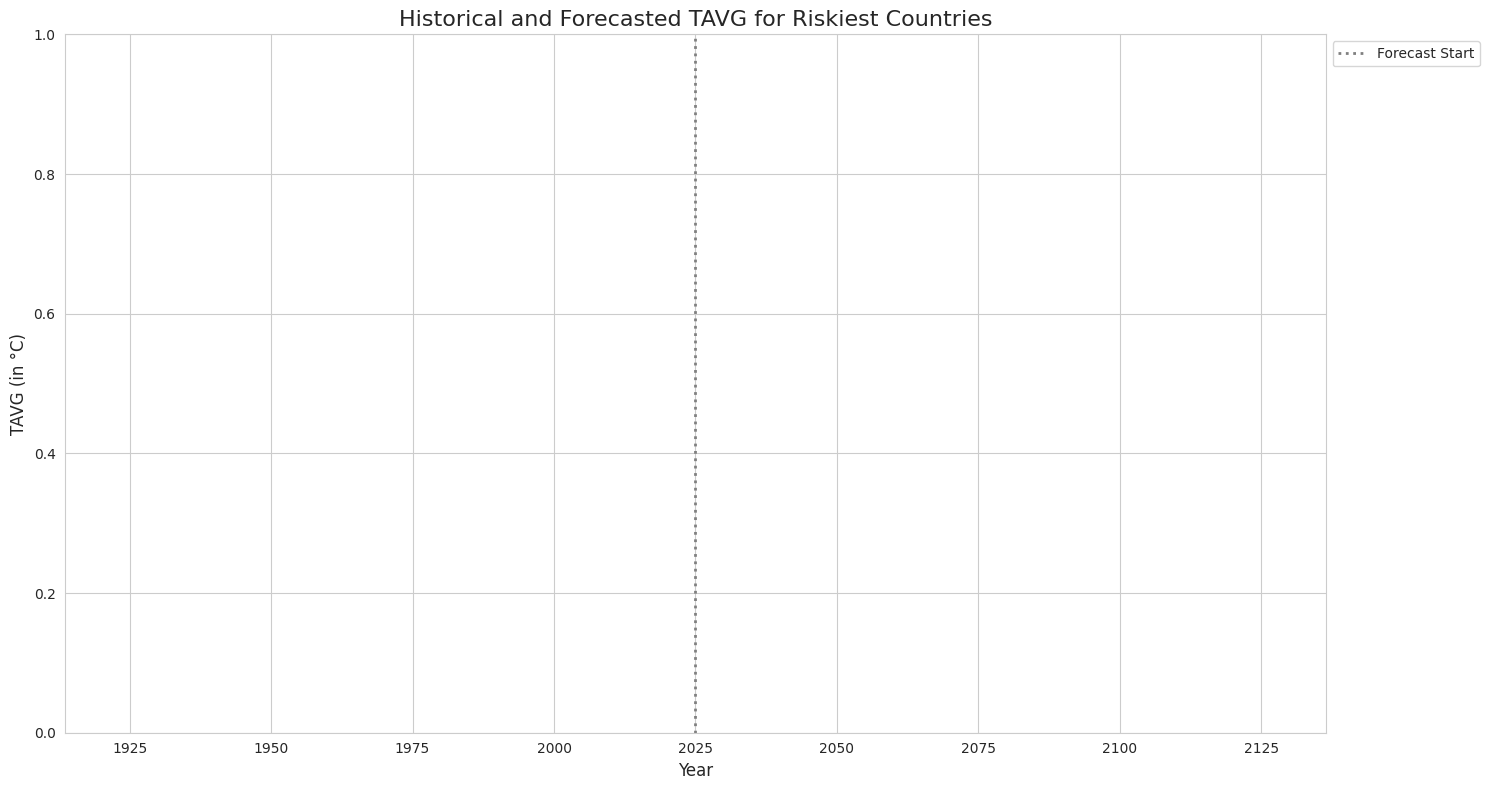


--- Starting Full Analysis for COLUMN: TMAX ---
Starting final model training for column: TMAX
  Order: (1, 1, 0), AIC: -73.06077612452124


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: -99.71878870752418
  Order: (1, 1, 0), AIC: 41.392204571625975
  Order: (0, 1, 1), AIC: 39.975057010390344
  Order: (1, 1, 0), AIC: 227.19551680247915
  Order: (0, 1, 1), AIC: 226.5981338420028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 95.56059124587603
  Order: (0, 1, 1), AIC: 83.96909186306104
  Order: (1, 1, 0), AIC: 163.46583088429762
  Order: (0, 1, 1), AIC: 159.68367437790684
  Order: (1, 1, 0), AIC: 21.624197953356905


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 21.566593985304205
  Order: (1, 1, 0), AIC: 9.06516364633811


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (0, 1, 1), AIC: 8.963114200406885
  Order: (1, 1, 0), AIC: 146.9863202320763
  Order: (0, 1, 1), AIC: 138.11046492332528


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (1, 1, 0), AIC: 79.4282852765978
  Order: (0, 1, 1), AIC: 79.35328120931045


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -67.08957056445027


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: -82.93062172059913
  Order: (1, 1, 0), AIC: 115.20899285506505
  Order: (0, 1, 1), AIC: 110.32207689758867
  Order: (1, 1, 0), AIC: 55.270021427174854
  Order: (0, 1, 1), AIC: 47.23806242851453


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 125.91736101216185
  Order: (0, 1, 1), AIC: 120.70737933926287
  Order: (1, 1, 0), AIC: 0.5225205621993334
  Order: (0, 1, 1), AIC: 0.12942658756058112


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 123.1627885552357
  Order: (0, 1, 1), AIC: 118.55440482945346
  Order: (1, 1, 0), AIC: 113.26846508733017
  Order: (0, 1, 1), AIC: 107.80684347681479


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 124.48445542435009
  Order: (0, 1, 1), AIC: 115.53785158234953
  Order: (1, 1, 0), AIC: 200.36264935274272
  Order: (0, 1, 1), AIC: 195.15926096224985
  Order: (1, 1, 0), AIC: 17.879774153162437


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 17.58623739460881
  Order: (1, 1, 0), AIC: 118.6386802373472
  Order: (0, 1, 1), AIC: 111.56601459331132
  Order: (1, 1, 0), AIC: 66.55263011775226
  Order: (0, 1, 1), AIC: 62.442620287380954


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 104.63157059602915
  Order: (0, 1, 1), AIC: 100.86134449410883
  Order: (1, 1, 1), AIC: 99.03152844288718
  Order: (1, 1, 0), AIC: 9.747521224809564
  Order: (0, 1, 1), AIC: 9.609070102505402


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 154.44210024954197
  Order: (0, 1, 1), AIC: 150.84606831210218
  Order: (1, 1, 0), AIC: 47.29434657331111
  Order: (0, 1, 1), AIC: 43.3245156942279


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 41.87873640247683
  Order: (1, 1, 0), AIC: 96.67720124921169
  Order: (0, 1, 1), AIC: 92.01649829268557
  Order: (1, 1, 0), AIC: 160.14685031324765
  Order: (0, 1, 1), AIC: 158.81380896100495


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 157.46720093557616
  Order: (1, 1, 0), AIC: 54.414172510068866
  Order: (0, 1, 1), AIC: 52.98348733526831
  Order: (1, 1, 0), AIC: 63.72660343762459
  Order: (0, 1, 1), AIC: 62.58682906498268


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 175.50061065018895
  Order: (0, 1, 1), AIC: 174.36439252282258
  Order: (1, 1, 0), AIC: 92.10762586960495
  Order: (0, 1, 1), AIC: 91.29600958693663


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 90.56266666850833
  Order: (1, 1, 0), AIC: 119.33794168320081
  Order: (0, 1, 1), AIC: 112.80714325205308
  Order: (1, 1, 0), AIC: 95.18259943921755
  Order: (0, 1, 1), AIC: 93.001506154935


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -8.9193903297392
  Order: (0, 1, 1), AIC: -9.091353198880961
  Order: (1, 1, 0), AIC: 84.0808759825897
  Order: (0, 1, 1), AIC: 80.64896550358904


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 122.94513878950174
  Order: (0, 1, 1), AIC: 119.16785860867776
  Order: (1, 1, 0), AIC: 90.7938344440314
  Order: (0, 1, 1), AIC: 88.77175610536435
  Order: (1, 1, 1), AIC: 86.55495415875298
  Order: (1, 1, 0), AIC: 50.72829296087606


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (0, 1, 1), AIC: 45.76574479556188
  Order: (1, 1, 0), AIC: 115.83985532515965
  Order: (0, 1, 1), AIC: 108.28752509120963
  Order: (1, 1, 0), AIC: 82.18895584487383


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (0, 1, 1), AIC: 81.40904511222524
  Order: (1, 1, 1), AIC: 80.42580733301581
  Order: (1, 1, 0), AIC: -32.256684340834084


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -32.367390845208625
  Order: (1, 1, 0), AIC: 106.84014065352727


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 99.38069552920493
  Order: (1, 1, 0), AIC: 16.618629314545853
  Order: (0, 1, 1), AIC: 15.315988765177867
  Order: (1, 1, 0), AIC: 51.261753648229956


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 51.25509786584438
  Order: (1, 1, 0), AIC: 108.6063147464933
  Order: (0, 1, 1), AIC: 107.78705629962924
  Order: (1, 1, 1), AIC: 104.78799444026176


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 68.5279369681709
  Order: (0, 1, 1), AIC: 65.63129057579437
  Order: (1, 1, 0), AIC: 59.269965755692084
  Order: (0, 1, 1), AIC: 53.225012000392226
  Order: (1, 1, 0), AIC: 220.92243710141196


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 102.71144787468265
  Order: (1, 1, 0), AIC: 98.56913876714874
  Order: (0, 1, 1), AIC: 98.4111233568234


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 82.73668123059403
  Order: (0, 1, 1), AIC: 82.01817063319845
  Order: (1, 1, 0), AIC: 115.40034372504535
  Order: (0, 1, 1), AIC: 108.93620180443024


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramet

  Order: (1, 1, 0), AIC: 161.11069948270045
  Order: (0, 1, 1), AIC: 157.15437462583836
  Order: (1, 1, 1), AIC: 153.91567817614887
  Order: (1, 1, 0), AIC: 115.89307175423625
  Order: (0, 1, 1), AIC: 105.3284630315331


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

  Order: (1, 1, 0), AIC: 143.33785560824637
  Order: (0, 1, 1), AIC: 140.58270603169038
  Order: (1, 1, 1), AIC: 138.50790381218658
  Order: (1, 1, 0), AIC: 96.96506181030256


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 108.15509381172367
  Order: (0, 1, 1), AIC: 95.77942614050804
  Order: (1, 1, 0), AIC: 185.89551699994723


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 49.46186583038618
  Order: (0, 1, 1), AIC: 40.760145018411855
  Order: (1, 1, 0), AIC: 162.5895370403523
  Order: (0, 1, 1), AIC: 161.60374656886648
  Order: (1, 1, 0), AIC: 114.56322786412088


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 111.2194289288916
  Order: (1, 1, 0), AIC: 114.61370170736511
  Order: (0, 1, 1), AIC: 108.66855656672718


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.34633308765007
  Order: (0, 1, 1), AIC: 67.78147633553236


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 63.222777670402586
  Order: (0, 1, 1), AIC: 60.01732384063277


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 59.93236014269197
  Order: (1, 1, 0), AIC: 127.00438363568466
  Order: (0, 1, 1), AIC: 114.42707799265804


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Final model training complete.
Generating forecasts for the next 10 years...
Forecasting complete.
Countries before final data frames: are 
 % 
 %
 %
 %
 
 
 
 
Successfully combined 






data for 65 countries.
Riskiest countries list saved to /content/drive/MyDrive/final_results/TMAX_riskiest_countries.csv
Figure saved to /content/drive/MyDrive/final_figures/TMAX_riskiest_countries.png


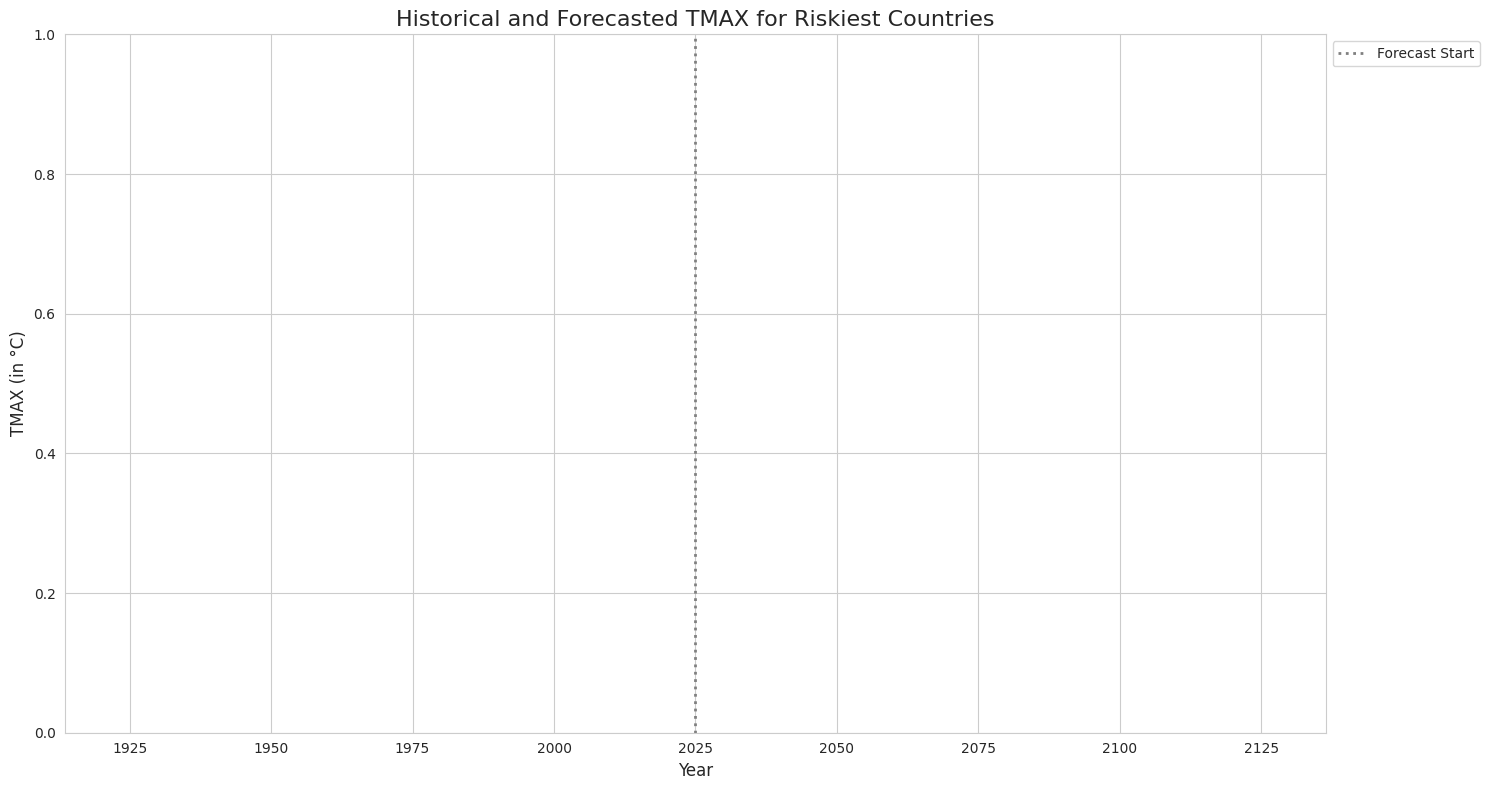


--- Starting Full Analysis for COLUMN: TMIN ---
Starting final model training for column: TMIN
  Order: (1, 1, 0), AIC: 61.741746248507006
  Order: (0, 1, 1), AIC: 54.56449223546053


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 195.70410025063063
  Order: (1, 1, 0), AIC: 132.71957858265372
  Order: (0, 1, 1), AIC: 123.48861890780178


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 123.25742553042569
  Order: (1, 1, 0), AIC: 38.71098580829512
  Order: (0, 1, 1), AIC: 33.18619972630415


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 85.78311607845939
  Order: (0, 1, 1), AIC: 78.91500919734129


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 142.8286173100295
  Order: (0, 1, 1), AIC: 132.06400454522102
  Order: (1, 1, 0), AIC: 119.89982279542282
  Order: (0, 1, 1), AIC: 119.02004359170033
  Order: (1, 1, 0), AIC: 83.27881090662326
  Order: (0, 1, 1), AIC: 81.50183654472252
  Order: (1, 1, 1), AIC: 79.88854998804014


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: -96.05686734402582
  Order: (1, 1, 0), AIC: 59.87268403493996
  Order: (0, 1, 1), AIC: 58.37444062525752


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 98.4215938600966
  Order: (0, 1, 1), AIC: 96.84139916811922
  Order: (1, 1, 1), AIC: 95.58689215046051
  Order: (1, 1, 0), AIC: 129.66393867826534
  Order: (0, 1, 1), AIC: 124.83718798243129
  Order: (1, 1, 1), AIC: 124.35677781743034


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 34.56483432765142
  Order: (0, 1, 1), AIC: 34.493198448255825
  Order: (1, 1, 0), AIC: 135.0625063457215
  Order: (0, 1, 1), AIC: 129.08733116074683
  Order: (1, 1, 0), AIC: 89.98319010884205


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 86.32200012925432
  Order: (1, 1, 0), AIC: 100.90642422134106
  Order: (0, 1, 1), AIC: 94.9912981604307
  Order: (1, 1, 0), AIC: 239.99246372514045


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 232.3395343662998
  Order: (1, 1, 1), AIC: 231.66816088328451
  Order: (1, 1, 0), AIC: 7.799978247148784
  Order: (0, 1, 1), AIC: 6.454105722735342
  Order: (1, 1, 0), AIC: 83.11707904845863
  Order: (0, 1, 1), AIC: 79.24874521031035


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 76.8878912497991
  Order: (0, 1, 1), AIC: 74.0464834401925
  Order: (1, 1, 0), AIC: 43.00921753543935


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 14.23429666660778
  Order: (0, 1, 1), AIC: 14.225373674070944


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 120.13948502071078
  Order: (0, 1, 1), AIC: 113.5861461047014
  Order: (1, 1, 0), AIC: 102.58768488575974
  Order: (0, 1, 1), AIC: 101.62449976306182
  Order: (1, 1, 1), AIC: 99.14050137330938
  Order: (1, 1, 0), AIC: 92.62802172558082


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 85.88245135451976
  Order: (1, 1, 0), AIC: 2.8279419490015334
  Order: (0, 1, 1), AIC: 2.4858750263164646
  Order: (1, 1, 1), AIC: 1.6651899459263486
  Order: (1, 1, 0), AIC: 108.71537128407503
  Order: (0, 1, 1), AIC: 100.47936390348482
  Order: (1, 1, 0), AIC: 125.63997400466491
  Order: (0, 1, 1), AIC: 112.89331028624792


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 1), AIC: 112.3383175134153
  Order: (1, 1, 0), AIC: -2.835117528988876
  Order: (0, 1, 1), AIC: -3.063264289673951
  Order: (1, 1, 0), AIC: 51.51166287734045
  Order: (0, 1, 1), AIC: 45.868658027409566


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 43.02928978766409
  Order: (0, 1, 1), AIC: 41.478392270529504
  Order: (1, 1, 0), AIC: 172.21389114525624
  Order: (0, 1, 1), AIC: 162.3253092454926
  Order: (1, 1, 0), AIC: 135.8788732796834


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 124.79887222484312
  Order: (1, 1, 0), AIC: 100.6173017100879
  Order: (0, 1, 1), AIC: 98.09238448350825
  Order: (1, 1, 1), AIC: 93.97448651065497
  Order: (1, 1, 0), AIC: 138.3801395318893
  Order: (0, 1, 1), AIC: 137.1009009195723


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as star

  Order: (1, 1, 1), AIC: 135.7731321836328
  Order: (1, 1, 0), AIC: 144.57367689494254
  Order: (0, 1, 1), AIC: 125.63160010032041
  Order: (1, 1, 0), AIC: 161.52042278475844
  Order: (0, 1, 1), AIC: 160.0150228156125


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 1), AIC: 157.61081448113154
  Order: (1, 1, 0), AIC: 112.02120529295854
  Order: (0, 1, 1), AIC: 110.84581186104948
  Order: (1, 1, 0), AIC: 100.61972047757946
  Order: (0, 1, 1), AIC: 91.96536837154518
  Order: (1, 1, 0), AIC: 98.13903602673828


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 95.04829217366468
  Order: (1, 1, 1), AIC: 94.34084329878625
  Order: (1, 1, 0), AIC: 62.28202220856138
  Order: (0, 1, 1), AIC: 58.160354372546706
  Order: (1, 1, 0), AIC: 57.89539354520439


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 53.17355600212472
  Order: (1, 1, 0), AIC: 111.05825860445565
  Order: (0, 1, 1), AIC: 104.82030736609478
Final model training complete.
Generating forecasts for the next 10 years...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Forecasting complete.
Countries before final data frames: are 
 % 
 %
 %
 %
 
 
 
 
Successfully combined 






data for 43 countries.
Riskiest countries list saved to /content/drive/MyDrive/final_results/TMIN_riskiest_countries.csv
Figure saved to /content/drive/MyDrive/final_figures/TMIN_riskiest_countries.png


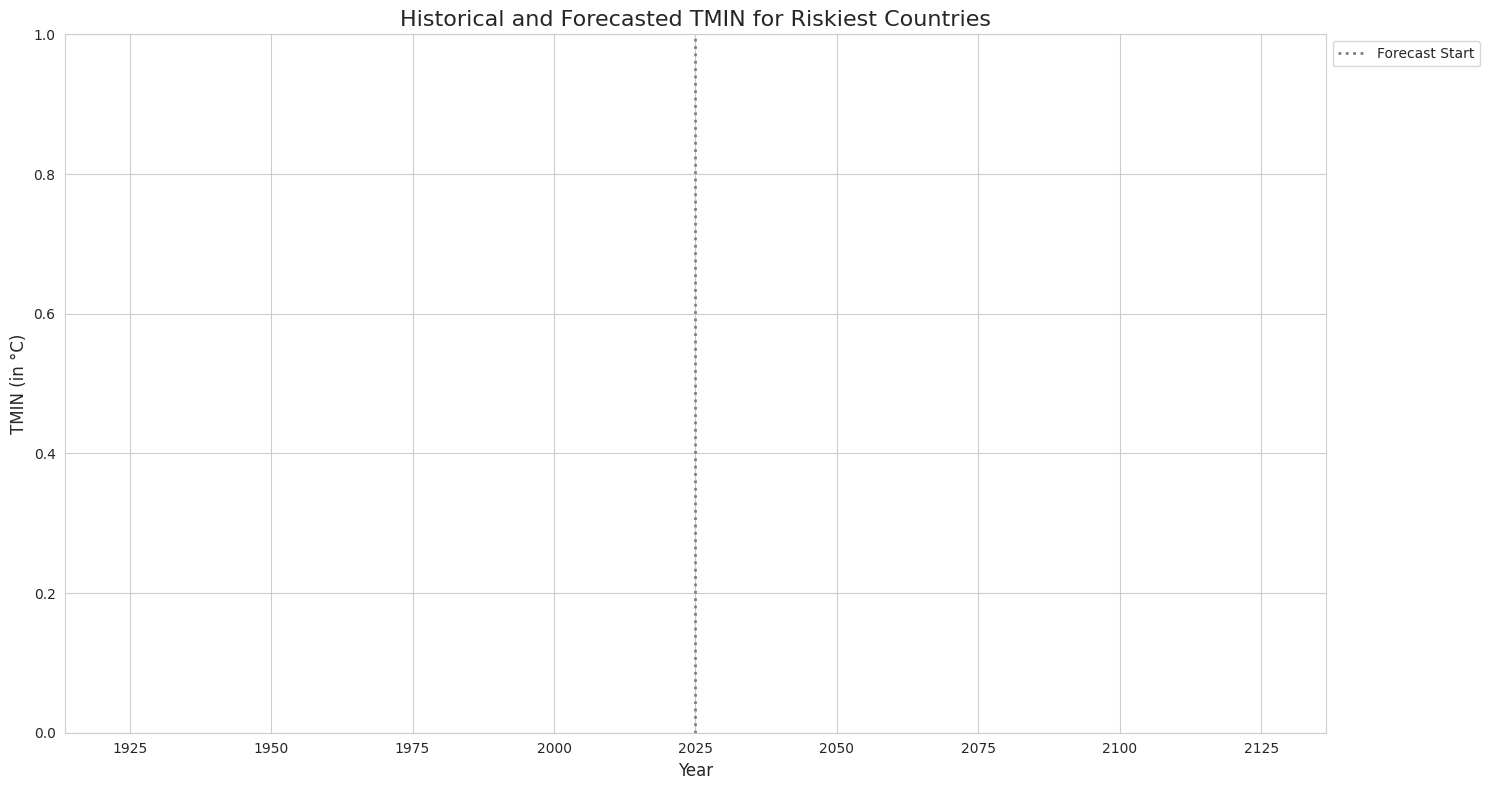


--- Starting Full Analysis for COLUMN: PRCP ---
Starting final model training for column: PRCP
  Order: (1, 1, 0), AIC: 428.6612813776399
  Order: (0, 1, 1), AIC: 428.6159168006695
  Order: (1, 1, 1), AIC: 428.4082065071336
  Order: (1, 1, 0), AIC: 722.7997736578491


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 710.193784560895
  Order: (1, 1, 0), AIC: 554.5211449279903
  Order: (0, 1, 1), AIC: 546.6689201871061
  Order: (1, 1, 1), AIC: 545.2625547789797


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 603.4570236256288
  Order: (0, 1, 1), AIC: 595.873581060089
  Order: (1, 1, 1), AIC: 593.3226549469352
  Order: (1, 1, 0), AIC: 522.2420213694907


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 513.1662958150736
  Order: (1, 1, 0), AIC: 557.014545278902
  Order: (0, 1, 1), AIC: 556.4769997089729


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 550.7197795137721
  Order: (1, 1, 0), AIC: 492.65089877137626
  Order: (0, 1, 1), AIC: 491.6327429197881
  Order: (1, 1, 0), AIC: 567.3926806410038


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (1, 1, 0), AIC: 556.3673964324319
  Order: (1, 1, 0), AIC: 494.72882949405084
  Order: (0, 1, 1), AIC: 494.3511367167015


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 548.8965759648585
  Order: (0, 1, 1), AIC: 539.2738605597859
  Order: (1, 1, 0), AIC: 590.6340071024529
  Order: (0, 1, 1), AIC: 567.9311746108812


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 558.6072308091001
  Order: (0, 1, 1), AIC: 541.0117485968045
  Order: (1, 1, 0), AIC: 360.83802230520007
  Order: (0, 1, 1), AIC: 358.78919892605126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 694.426578749491
  Order: (0, 1, 1), AIC: 676.0489930878762
  Order: (1, 1, 0), AIC: 682.0867843797374
  Order: (0, 1, 1), AIC: 672.5966513554273
  Order: (1, 1, 0), AIC: 535.7333359514813
  Order: (0, 1, 1), AIC: 516.2266542664028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramet

  Order: (1, 1, 0), AIC: 565.2574969019417
  Order: (0, 1, 1), AIC: 560.6907494147324
  Order: (1, 1, 0), AIC: 711.2005579001069
  Order: (0, 1, 1), AIC: 694.1950931255344


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 602.428512758987
  Order: (1, 1, 0), AIC: 480.3076615003022


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 554.5999455582929
  Order: (0, 1, 1), AIC: 540.3892313540823
  Order: (1, 1, 0), AIC: 584.6871491901147
  Order: (0, 1, 1), AIC: 574.4618755026742


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 667.7990938849169
  Order: (0, 1, 1), AIC: 665.4995471560297
  Order: (1, 1, 1), AIC: 664.743431385192
  Order: (1, 1, 0), AIC: 701.4690366976864
  Order: (0, 1, 1), AIC: 695.6498748822305


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 694.7184582806306
  Order: (1, 1, 0), AIC: 522.6871372158803
  Order: (0, 1, 1), AIC: 506.6557281491448
  Order: (1, 1, 0), AIC: 529.7621456490543
  Order: (0, 1, 1), AIC: 529.0499165068647


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 1), AIC: 526.6829563028247
  Order: (1, 1, 0), AIC: 573.7495547511029
  Order: (0, 1, 1), AIC: 555.1802587576839
  Order: (1, 1, 0), AIC: 360.826732667973
  Order: (0, 1, 1), AIC: 355.6989991588018


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 546.27557787497
  Order: (0, 1, 1), AIC: 538.8310658992038


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 627.3232644214513
  Order: (0, 1, 1), AIC: 621.8446778089975


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 179.49744815025048
  Order: (0, 1, 1), AIC: 173.65937449275174


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 571.2509912287119
  Order: (0, 1, 1), AIC: 566.7767281038687


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 565.6185747694698
  Order: (1, 1, 0), AIC: 666.5062948009078
  Order: (0, 1, 1), AIC: 663.0392378179846


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

  Order: (1, 1, 1), AIC: 656.256720655828
  Order: (1, 1, 0), AIC: 437.88954691910885
  Order: (0, 1, 1), AIC: 432.58943514719635


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 703.9973927985367
  Order: (0, 1, 1), AIC: 683.4821815462174


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 514.808472417049
  Order: (0, 1, 1), AIC: 514.6498420866699


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 638.9875674438791
  Order: (0, 1, 1), AIC: 638.6344755014406
  Order: (1, 1, 0), AIC: 583.4117996429745


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (0, 1, 1), AIC: 568.4419602186847
  Order: (1, 1, 0), AIC: 611.4591947110238
  Order: (0, 1, 1), AIC: 610.1509069738324
  Order: (1, 1, 1), AIC: 610.0551791466947
  Order: (1, 1, 0), AIC: 565.3429760023113
  Order: (0, 1, 1), AIC: 558.8859567372602
  Order: (1, 1, 0), AIC: 244.32509065478501


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 244.27113994815733
  Order: (1, 1, 0), AIC: 665.13704896067
  Order: (0, 1, 1), AIC: 649.3405385287218


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 534.8084320195934
  Order: (0, 1, 1), AIC: 524.6307600179076
  Order: (1, 1, 0), AIC: 552.4919067363979
  Order: (0, 1, 1), AIC: 548.6051998394057
  Order: (1, 1, 1), AIC: 548.3688827276048
  Order: (1, 1, 0), AIC: 671.2105822635222
  Order: (0, 1, 1), AIC: 657.0493755289315
  Order: (1, 1, 0), AIC: 555.845245898744


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (0, 1, 1), AIC: 551.7047090138349
  Order: (1, 1, 0), AIC: 396.8640182046748
  Order: (0, 1, 1), AIC: 391.3037494992846
  Order: (1, 1, 1), AIC: 390.48622325613417


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramet

  Order: (1, 1, 0), AIC: 628.1704231638921
  Order: (0, 1, 1), AIC: 627.3484425028748
  Order: (1, 1, 0), AIC: 567.0926170870184
  Order: (0, 1, 1), AIC: 562.3848487846332


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be use

  Order: (1, 1, 0), AIC: 543.6924164525558
  Order: (0, 1, 1), AIC: 525.9773974420241
  Order: (1, 1, 0), AIC: 502.2319999697528
  Order: (0, 1, 1), AIC: 488.7219846634035
  Order: (1, 1, 0), AIC: 664.4343207477024


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freq

  Order: (1, 1, 0), AIC: 525.236873672429
  Order: (0, 1, 1), AIC: 523.9932621112268
  Order: (1, 1, 0), AIC: 191.64288071638714


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided,

  Order: (1, 1, 0), AIC: 481.69182418281724
  Order: (0, 1, 1), AIC: 476.6868617167284
  Order: (1, 1, 0), AIC: 578.4962002063638
  Order: (0, 1, 1), AIC: 564.674871939434


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 483.8726981430576
  Order: (0, 1, 1), AIC: 477.23038694070647
  Order: (1, 1, 1), AIC: 476.56765021043844
  Order: (1, 1, 0), AIC: 312.7364637948261
  Order: (0, 1, 1), AIC: 312.3230066022151


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Final model training complete.
Generating forecasts for the next 10 years...
Forecasting complete.
Countries before final data frames: are 
 % 
 %
 %
 %
 
 
 
 
Successfully combined 






data for 59 countries.
Riskiest countries list saved to /content/drive/MyDrive/final_results/PRCP_riskiest_countries.csv
Figure saved to /content/drive/MyDrive/final_figures/PRCP_riskiest_countries.png


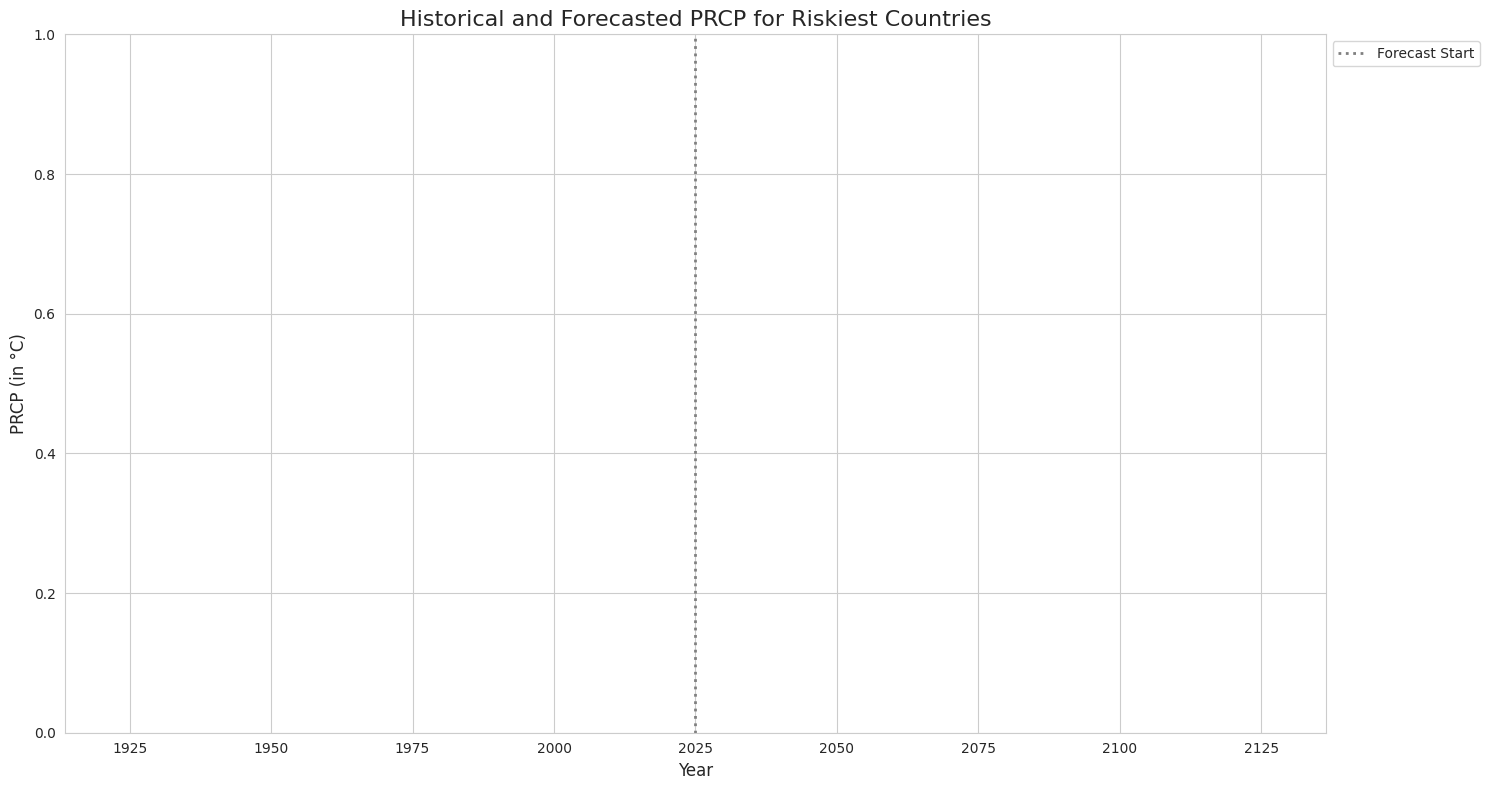

In [144]:
if __name__ == '__main__':
    data_file_path = f'{basePath}/data/processed/trimmedData.csv'
    arima_orders_final = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    columns_to_analyze = ['TAVG', 'TMAX', 'TMIN', 'PRCP']

    try:
        df_raw = pd.read_csv(data_file_path)
        print("Raw data loaded successfully.")

        for column_to_analyze in columns_to_analyze:
            print(f"\n--- Starting Full Analysis for COLUMN: {column_to_analyze} ---")

            df_train, df_test = prepare_column_data_pipeline(df_raw, column_name=column_to_analyze)
            df_combined = combine_data_for_final_training(df_train, df_test)

            last_historical_year = df_combined['DATE'].max()

            final_models_dict = train_final_models(df_combined, column_name=column_to_analyze, arima_orders=arima_orders_final)

            forecasts_dict = forecast_future_values(final_models_dict, df_combined, forecast_years=10, column_name=column_to_analyze)

            df_final = combine_historical_and_forecasts(df_combined, forecasts_dict, column_name=column_to_analyze)

            risky_changes = {}
            for country in df_final['COUNTRY'].unique():
                country_data = df_final[df_final['COUNTRY'] == country].copy()
                historical_data = country_data[country_data['DATE'] <= last_historical_year]
                forecast_data = country_data[country_data['DATE'] > last_historical_year]

                if len(historical_data) >= 10 and len(forecast_data) >= 10:
                    historical_avg = historical_data[column_name].tail(10).mean()
                    forecast_avg = forecast_data[column_name].head(10).mean()
                    risk_metric = abs(forecast_avg - historical_avg)
                    risky_changes[country] = risk_metric

            top_n = 5
            riskiest_countries_list = sorted(risky_changes, key=risky_changes.get, reverse=True)[:top_n]

            riskiest_df = pd.DataFrame(list(risky_changes.items()), columns=['COUNTRY', 'RISK_METRIC'])
            riskiest_df = riskiest_df.sort_values(by='RISK_METRIC', ascending=False)

            results_dir = f'{basePath}/final_results'
            os.makedirs(results_dir, exist_ok=True)
            results_path = os.path.join(results_dir, f'{column_to_analyze}_riskiest_countries.csv')
            riskiest_df.to_csv(results_path, index=False)
            print(f"Riskiest countries list saved to {results_path}")

            figure_save_path = f'{basePath}/final_figures/{column_to_analyze}_riskiest_countries.png'
            plot_country_forecasts(df_final, riskiest_countries_list, column_name=column_to_analyze, last_historical_year=last_historical_year, save_path=figure_save_path)

    except Exception as e:
        print(f"\nAn error occurred during the final pipeline run: {e}")